<h1>IS4242 Group Project</h1>

<b>Import necessary libraries</b>

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE

<h5>Running the code</h5>
Ensure that you are in the root folder of all the fold folders and target files
read_text(fold_name):
    fold_name: this is the name of the fold you want to read ALL patient files of. It will be read into a 2 dimensional
    list. If you would like to retrieve just the first patient instead, you will need to change the line 
    "txt_all.extend(txt[1:])" to "txt_all.append(txt[1:])" and you will be to use "read_text(fold1.txt)[0]" to retrieve
    the relevant patient's data
read_ans(file_name):
    file_name: this is the name of the file you want to read ALL targets of. It will be read into a 2 dimensional
    list. To retrieve the first patient's target: read_ans(ans.csv)[0]
put_single_into_dataframe(txt): This functions takes in 2 dimensional list ie the output of read_text(fold1.txt) 
put_multiple_into_dataframe(txt): Multiple is for using it with the output of read_text after you wanted to change it to append


In [2]:
def read_text(fold_name):
    txt_all = list()
    for f in os.listdir(fold_name): # for each file in the directory
        if f.endswith(".txt"):
            with open(os.path.join(fold_name, f), 'r') as fp: # open each file
                txt = fp.readlines() # read inside the file
                recordid = txt[1].rstrip('\n').split(',')[-1] # get recordid
                txt = [[int(recordid)] + t.rstrip('\n').split(',') for t in txt] # preface each row with the recordid as all patients are 1 file
                txt_all.extend(txt[1:]) # skip the parameter list
    return txt_all

def read_one_text(fold_name):
    txt_all = list()
    for f in os.listdir(fold_name): # for each file in the directory
        if f.endswith(".txt"):
            with open(os.path.join(fold_name, f), 'r') as fp: # open each file
                txt = fp.readlines() # read inside the file
            recordid = txt[1].rstrip('\n').split(',')[-1] # get recordid
            txt = [[int(recordid)] + t.rstrip('\n').split(',') for t in txt] # preface each row with the recordid as all patients are 1 file
            txt_all.append(txt[1:]) # skip the parameter list
    return txt_all

def read_ans(file_name):
    txt_all = list()
    with open(file_name, 'r') as fp: # opens the csv file
        txt = fp.readlines() 
    for i in range(1, len(txt)): # similar to above read_text
        record_id, length_of_stay, hospital_death = txt[i].rstrip('\n').split(',')
        txt_all.append([record_id, length_of_stay, hospital_death])
    return txt_all

def put_multiple_into_dataframe(txt_all):
    df = pd.DataFrame()
    for i in txt_all:
        df2 = pd.DataFrame(i, columns=['recordid', 'time', 'parameter', 'value'])
        df = df.append(df2, ignore_index=True)
    return df

def put_single_into_dataframe(txt_all):
    df = pd.DataFrame(txt_all, columns=['recordid', 'time', 'parameter', 'value'])
    return df

def get_X_add_ready(X_add, stat):
    X_add = X_add.reset_index()
    X_add = X_add.pivot(index='recordid', columns='parameter', values='value')
    X_add = X_add.drop(stat_feat, axis = 1) 
#     X_add = X_add.drop(['RecordID'], axis = 1) 
    X_add.columns = [x+stat for x in X_add.columns]
    X_add = X_add.reset_index()
    return X_add

<h1>1. Data Exploration</h1>

Firstly, read_one_text function is used to read in the folder (eg. Fold1) containing the patient's individual record file. The index 0 in this case in the first line: p1 = read_one_text('../Project_Data/Fold1')[0] is to retrieve the first patient's record in the folder entered inside the function read_one_text. For example, to retrieve the last patient record in Fold3 folder, one has to type: p1 = read_one_text('../Project_Data/Fold3')[999]

Format to get individual record:  
Line 1: p1 = read_one_text('../Project_Data/<b>x</b>')[<b>y</b>]  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>x</b> = folder of the patient to retrieve  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>y</b> = index row of the patient inside the folder - 1

Next, this patient record will then undergo preprocessing steps as follows to remove unnecessary information and transform the data into a more meaningful one. This patient record is transformed into dataframe with the columns 'recordid', 'time', 'parameter', 'value'. The recordid of this patient is stored in a variable called 'recordId' before dropping both the column 'recordid' and the first row in the dataframe which contains the recordid of this patient as they are now redundant. 

Subsequently, data in the column for 'value' is converted to numeric so as to facilitate the plotting of graph later. A new column called 'time_value' is created to store a tuple of 'time' and 'value'. The dataframe is then grouped by the 'parameter' column and then the 'time_value' tuple is then stored in a list based on the parameter. 

Finally, the groupby object is then plotted into a graph with each unique parameter as a different line in the graph with the x-axis in hours and y-axis as the values which the parameter is measured.

C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


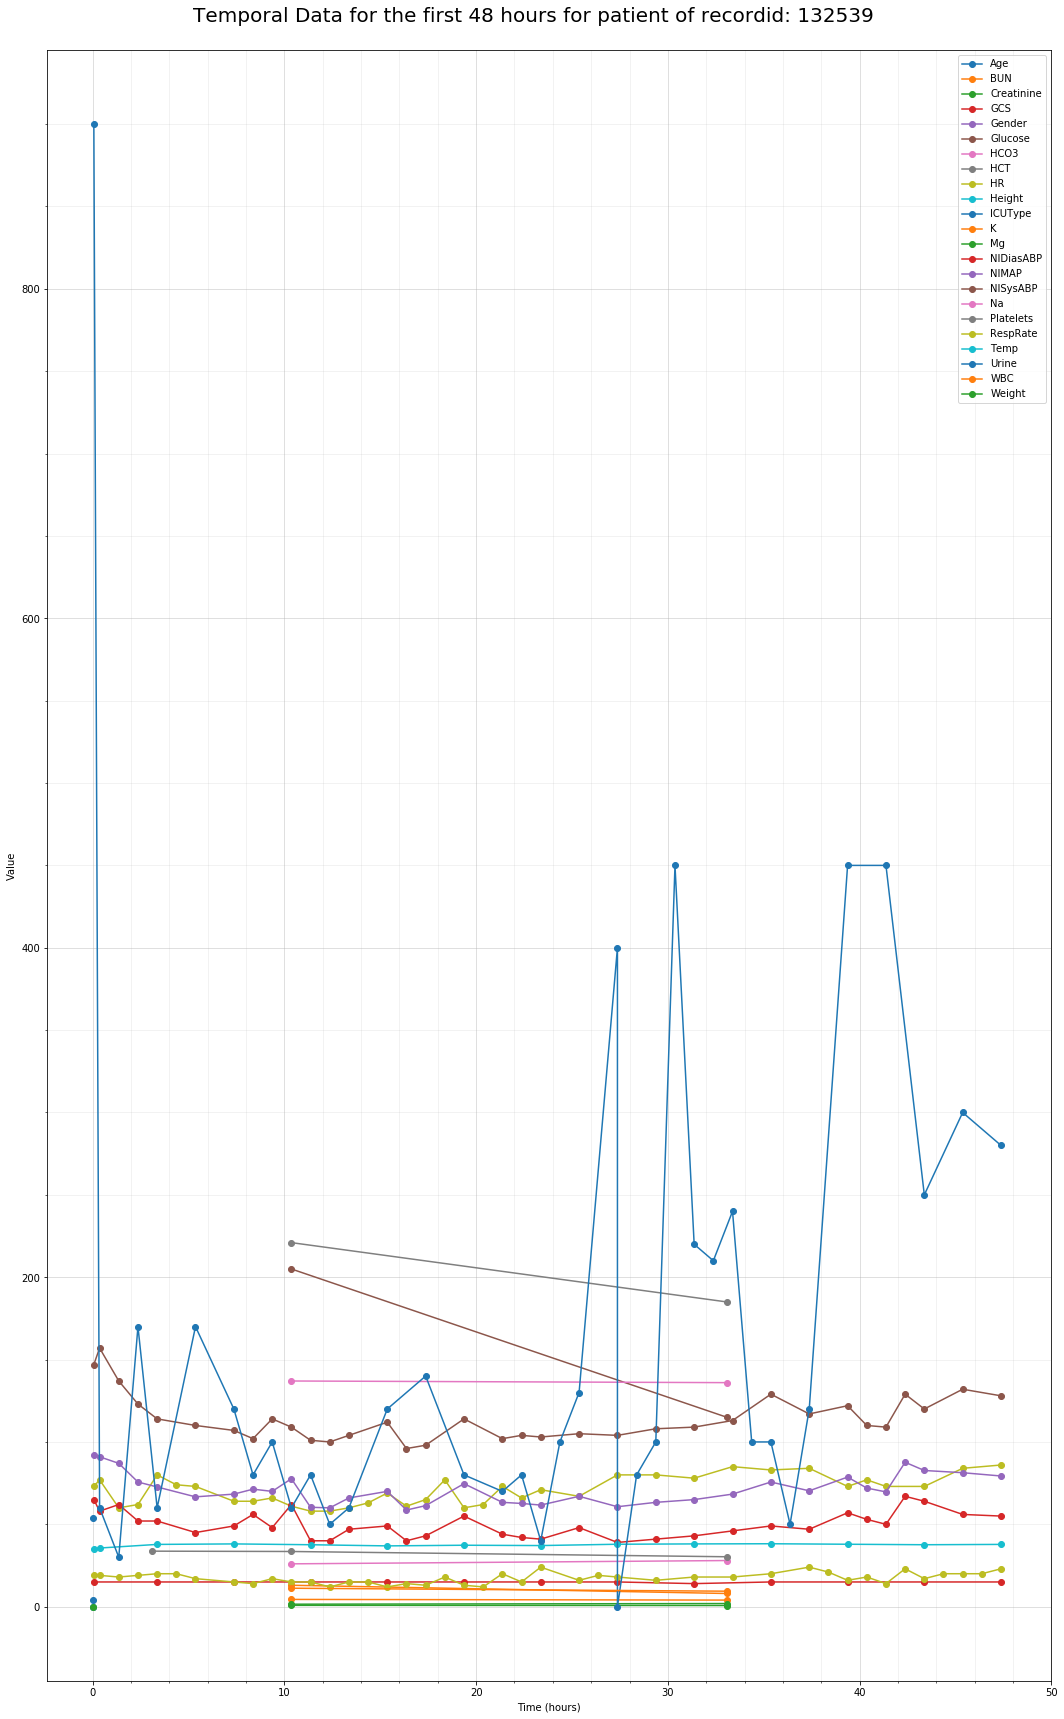

In [3]:
p1 = read_one_text("../Project_Data/Fold1")[0]
p1df = pd.DataFrame(p1, columns=['recordid', 'time', 'parameter', 'value'])
recordId = p1df.iloc[0]['value']
df_1 = p1df.drop('recordid', axis=1)
df_1.drop(df_1.index[:1], inplace=True)
# df_1

df_1['value'] = pd.to_numeric(df_1['value'])
df_1.time = df_1.time.astype('str')
df_1['time'] = df_1['time'].str.replace(':', '.')
df_1['time'] = pd.to_numeric(df_1['time'])
df_1['value'][df_1['value'] < 0] = 0
df_1['time_value'] = list(zip(df_1.time, df_1.value))
df_2 = df_1.groupby('parameter').time_value.apply(lambda x: x.unique().tolist())

major_ticks = np.arange(0, 51, 10)
minor_ticks = np.arange(0, 49, 2)
fig = plt.figure(figsize=(18, 30))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(df_2)):
    testList2 = [(elem1, elem2) for elem1, elem2 in df_2[i]]
    zip(*testList2)
    plt.plot(*zip(*testList2), marker='o', label=df_2.index[i])
plt.xlabel('Time (hours)')
plt.ylabel('Value')
plt.legend(loc='upper right')
title = 'Temporal Data for the first 48 hours for patient of recordid: ' + recordId
fig.suptitle(title, fontsize=20, y=0.9)
# plt.xlim(xmin=0.0)
# plt.ylim(ymin=0.0)
ax.minorticks_on()
ax.set_xticks(minor_ticks, minor=True)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
# ax.tick_params(which = 'both', direction = 'out')
plt.show()

In [3]:
df_feat = pd.DataFrame()
numberOfFolds = 0
for i, name in enumerate(["Fold1"]): # what folds do you want to use?
    string = "../Project_Data/"
    string += name
    df_feat = df_feat.append(put_single_into_dataframe(read_text(string)))
    numberOfFolds = (i+1)
numberOfRows = numberOfFolds*1000
df_feat.head()

,recordid,time,parameter,value
0,132539,00:00,RecordID,132539
1,132539,00:00,Age,54
2,132539,00:00,Gender,0
3,132539,00:00,Height,-1
4,132539,00:00,ICUType,4


In [4]:
# Reading Target
df_target = pd.DataFrame(read_ans('../Project_Data/Fold1_Outcomes.csv'), columns=['recordid', 'days_in_hospital', 'mortality'])
df_target.head()

,recordid,days_in_hospital,mortality
0,132539,5,0
1,132540,8,0
2,132541,19,0
3,132543,9,0
4,132545,4,0


In [5]:
bin_feat = ['MechVent']
num_feat = ['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Cholesterol',
           'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT',
           'HR', 'K', 'Lactate', 'Mg', 'MAP', 'NA', 'NIDiasABP', 'NIMAP',
           'NISysABP', 'PaCO2', 'PaO2', 'pH', 'Platelets', 'RespRate', 'SaO2',
           'SysABP', 'Temp', 'Tropl', 'TropT', 'Urine', 'WBC', 'Weight']

print("Number of record ids:", len(df_feat['recordid'].unique()))
unique_count = df_feat['parameter'].value_counts()/numberOfRows
print(unique_count)

Number of record ids: 1000
HR             57.027
MAP            36.092
SysABP         35.979
DiasABP        35.955
Urine          34.208
Weight         33.679
NISysABP       24.457
NIDiasABP      24.424
NIMAP          24.088
Temp           21.204
GCS            15.214
RespRate       13.775
FiO2            7.815
MechVent        7.596
pH              5.770
PaO2            5.496
PaCO2           5.490
HCT             4.626
K               3.708
Creatinine      3.573
Platelets       3.566
BUN             3.547
HCO3            3.479
Mg              3.468
Na              3.462
Glucose         3.338
WBC             3.286
SaO2            1.985
Lactate         1.924
Height          1.000
RecordID        1.000
ICUType         1.000
Gender          1.000
Age             1.000
Bilirubin       0.858
AST             0.857
ALT             0.857
ALP             0.833
Albumin         0.617
TroponinT       0.566
TroponinI       0.130
Cholesterol     0.077
Name: parameter, dtype: float64


<h2>Analysis of Features</h2>
<p>The data above shows the average number of times a variable observed per patient. Based on the data above and the feature description we classify the features into these categories:
<ul>
    <li>General Descriptors (static data) that are collected when the patient is admitted to the ICU. Weight is not included as weight are measured multiple times as a time series data. Each of the descriptors will be included as a feature into the model.</li>
    <li>Rare features: measured on average less than one time per patient (less than 1.0). We use the <u>existence</u> of these measurements for each patient as a feature.</li>
    <li>Features that measured often or more that one time per patient (more than 1.0). Calculate the hourly average of each measurements and put them into 48 columns. <i>Example, average HR on the first hour to HR_1, average HR on the second hour to HR_2, and so on.</i></li>
</ul>
</p>


In [6]:
stat_feat = ['Age', 'Gender', 'Height', 'ICUType', 'RecordID'] #General Descriptors
rare_feat = []
nor_feat = []
for index, value in unique_count.items():
    if value < 1.0:
        rare_feat.append(index)
    elif index not in stat_feat:
        nor_feat.append(index)
rare_feat.append("MechVent")
print("Rare features", rare_feat)
print("Normal features", nor_feat)

Rare features ['Bilirubin', 'AST', 'ALT', 'ALP', 'Albumin', 'TroponinT', 'TroponinI', 'Cholesterol', 'MechVent']
Normal features ['HR', 'MAP', 'SysABP', 'DiasABP', 'Urine', 'Weight', 'NISysABP', 'NIDiasABP', 'NIMAP', 'Temp', 'GCS', 'RespRate', 'FiO2', 'MechVent', 'pH', 'PaO2', 'PaCO2', 'HCT', 'K', 'Creatinine', 'Platelets', 'BUN', 'HCO3', 'Mg', 'Na', 'Glucose', 'WBC', 'SaO2', 'Lactate']


In [7]:
# your code to produce test and train data
df = df_feat.copy()

<h2>Creation of Data Matrices</h2>
<p>We create 3 different matrices to convert temporal data into a matrix that is a single feature vector per patient.</p>
<h3>First Design Matrix</h3>
<ul> 
    <li>In the cell below, we create a matrix that generalises a patient's attributes across the whole 48 hours, such as his max BUN measurement over the 48 hours. This is so as to create a much denser feature matrix as well as provide a much clearer signal to the learner, allowing it to generalise to data outside of the train set.</li>
    <li>We will be utilising the min, max and mean of the measurements</li>
    <li>We have converted sparse features like ALS into a binary variable where 1 represents "It was recored" and 0 representing "It was not recorded at all".</li>
    <li>ICUType was one-hot encoded</li>
</ul>

In [8]:
def preprocess_x_for_design_matrix_1(df_feat):
    non_bin_feat.clear()
    # your code to produce test and train data
    df = df_feat.copy()

    df['value'] = pd.to_numeric(df['value'])
    temp_df = df.loc[df['time'] == '00:00', :].copy() # get all the variables at time 0
    temp_df = temp_df.loc[temp_df['parameter'].isin(stat_feat)] # prune the dataframe to only those static variables
    temp_df = temp_df.pivot(index='recordid', columns='parameter', values='value') 
    temp_df = temp_df.reset_index()
    for i in temp_df: # for loop to change all the -1 values for static variables into np.nan
        idx = temp_df.index[temp_df[i] == -1].tolist()
        for j in idx:
            temp_df.loc[j, i] = np.nan
    final_df = temp_df.copy()

#     Dealing with rare_feat
    d = df_feat.groupby(['recordid', 'parameter'])[['value']].count()
    def specialFeature(special):
        id = []
        for index, row in d.iterrows():
            if index[1] == special:
                id.append(index[0])
        return id
    for x in rare_feat:
        id = specialFeature(x)
        final_df[x] = 0
        for i in id:
            for row in final_df.index:
                if row == i:
                    final_df.loc[row, x] = 1
    final_df = final_df.drop(["RecordID"],axis=1)

    # Getting the different attributes
    pd.set_option('display.max_columns', 500)
    temp_df = df.drop(df.index[df['parameter'].isin(rare_feat)].tolist())
    temp_df = temp_df.groupby(['recordid', 'parameter'])[['value']]
    for i in ['min', 'max', 'mean']: # the different parameters we will use
        if (i=='min'):
            X_add = temp_df.min() # get the min of each parameter
            X_add = get_X_add_ready(X_add, '_min')
            final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe
        elif (i=='max'):
            X_add = temp_df.max() # get the max of each parameter
            X_add = get_X_add_ready(X_add, '_max')
            final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe
        elif (i=='mean'):
            X_add = temp_df.mean() # get the mean of each parameter
            X_add = get_X_add_ready(X_add, '_mean')
            final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe

    # dealing with ICUType categorical
    one_hot = pd.get_dummies(final_df['ICUType'])
    meaning_of_icu_types = {1:'Coronary Care Unit', 2: 'Cardiac Surgery Recovery Unit', 3: 'Medical ICU', 4: 'Surgical ICU'}
    one_hot.columns = [meaning_of_icu_types[x] for x in one_hot.columns]
    final_df = final_df.merge(one_hot, left_index=True, right_index=True)
    final_df = final_df.drop('ICUType', axis=1)
    
    # Extreme height values is set to np.nan
    for index, row in final_df.iterrows():
        if row["Height"] < 40 or row["Height"] > 210:
            row["Height"] = np.nan


    # Drop recordID column
    final_df = final_df.drop("recordid", axis=1)
            
    # Creating non binary column list and filling na values with mean
    for i in final_df:
        if i in rare_feat or i in bin_feat:
            continue
        final_df = final_df.fillna(final_df.mean())
        non_bin_feat.append(i)
        
#     display(final_df.head())
    return final_df

<h3>Second Design Matrix</h3>
<ul> 
    <li>The second design matrix is created in such a way that every parameters is grouped into a 12-hour bin (eg. 0-12, 12-24, 24-36, 36-48). If a parameter is measured multiple times within a 12-hour bin, a mean of those measurement will be recorded to represent the measurement for that 12-hour bin instead. The assumption for using the mean for 12-hour is that once patients are sent to the ICU, they must be closely monitored and furthermore, the working shift of nurses in hospital is usually by 12-hour and so this ensures lesser human errors when the nurses change shift and patient is being measured.</li>
        <li>We have converted sparse features like ALS into a binary variable where 1 represents "It was recored" and 0 representing "It was not recorded at all".</li>
    <li>ICUType was one-hot encoded</li>
</ul>

In [29]:
# Second Matrix
def preprocess_x_for_design_matrix_2(df):
    non_bin_feat.clear()
    
    # retrieving static data of the patients at time 0 and transformed into dataframe with static feature as the column 
    # headers and each row in the dataframe representing each patient record, which is indexed by their record id
    df_static = df.loc[df['time'] == '00:00', :].copy()
    static_vars = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
    df_static.drop('time', axis=1, inplace=True)
    df_static = df_static.loc[df_static['parameter'].isin(static_vars)]
    df_static = df_static.groupby(['recordid', 'parameter'])[['value']].last()
    df_static.reset_index(inplace=True)
    df_static = df_static.pivot(index='recordid', columns='parameter', values='value')

    for c in df_static.columns:
        df_static[c] = pd.to_numeric(df_static[c])

    # replacing height and weight which does not exist (represented with '-1') with NaN
    for c in df_static.columns:
        x = df_static[c]
        if c == 'Height':
            idx = x < 0
            df_static.loc[idx, c] = np.nan
        elif c == 'Weight':
            idx = x < 0
            df_static.loc[idx, c] = np.nan
    d = df.groupby(['recordid', 'parameter'])[['value']].count()
    def specialFeature(special):
        id = []
        for index, row in d.iterrows():
            if index[1] == special:
                id.append(index[0])
        return id

    # RecordID column is dropped as every row is already indexed by the recordid
    df2 = df_static.copy()
    df2.drop('RecordID', axis=1, inplace=True)

    # rare features which are rarely measured such as Cholesterol are converted to binary features which indicates whether 
    # any measurement for these variables were recorded within the first 48 hours. Binary feature was also created for 
    # MechVent to indicate whether the patient was placed on mechanical ventilation
    for x in rare_feat:
        id = specialFeature(x)
        df2[x] = 0
        for i in id:
            for row in df2.index:
                if row == i:
                    df2.loc[row, x] = 1
    df2.head()
    normal_feat = nor_feat.copy()
    normal_feat.remove('MechVent')
    
    # grouped the rest of the parameters into 12-hour bins and the mean of the parameter in a given 12-hour interval
    # is taken if it was measured more than once during that 12-hour interval
    idx = df['parameter'].isin(normal_feat)
    df3 = df.loc[idx, :].copy()
    df3[['hour','min']] = df3.time.str.split(':', expand=True)
    df3["hour"] = pd.to_numeric(df3["hour"])
    df3["value"] = pd.to_numeric(df3["value"])
    bins = [0, 12, 24, 36, 48]
    labels = ['0', '12', '24', '36']
    
    # grouped by recordid first, then by each 12-hour interval then by the parameters
    df3 = df3.groupby(['recordid', pd.cut(df3.hour, bins=bins, labels=labels), 'parameter'])[['value']].mean()
    df3

    # filled in the dataframe with NaN first
    for n in normal_feat:    
        df2[n +'0'] = np.nan
        df2[n +'12'] = np.nan
        df2[n +'24'] = np.nan
        df2[n +'36'] = np.nan
    df2.head()

    # go through every row in groupby table and insert these values into the dataframe with NaN, replacing them
    for index, row in df3.iterrows():
        recordId = index[0]
        hour = index[1]
        parameter = index[2]
        df2.loc[recordId, parameter+hour] = row["value"]

    one_hot = pd.get_dummies(df2['ICUType'])
    meaning_of_icu_types = {1:'Coronary Care Unit', 2: 'Cardiac Surgery Recovery Unit', 3: 'Medical ICU', 4: 'Surgical ICU'}
    one_hot.columns = [meaning_of_icu_types[x] for x in one_hot.columns]
    df2 = df2.merge(one_hot, left_index=True, right_index=True)
    df2 = df2.drop('ICUType', axis=1)
    
    # Extreme height values is set to np.nan
    for index, row in df2.iterrows():
        if row["Height"] < 40 or row["Height"] > 210:
            row["Height"] = np.nan
            
    # Creating non binary column list and filling na values with mean
    for i in df2:
        if i in rare_feat or i in bin_feat:
            continue
        df2 = df2.fillna(df2.mean())
        non_bin_feat.append(i)

    display(df2.head())
    return df2

<h3>Third Design Matrix</h3>
<p>This design matrix splits all numerical time series data into hourly bins. The average value of the measurements on each hour will be taken and put into the columns. The idea of this is to get the condition of the patient on each hour from coming in to the hospital until the 48 hour mark. All rare features will be taken as a binary feature of whether the measurement appear within 48 hours. All general descriptors taken as it is except weight.</p>

In [8]:
def preprocess_x_for_design_matrix_3(df_feat):
    df = pd.DataFrame()
    
    tot_values = {} # the sum of the values
    count = {} # num of occurences of a measurement
    for index,row in df_feat.iterrows():
        if row['parameter'] == 'RecordID' and index != 0:
            # count the average of the previous record
            for key,value in tot_values.items():
                tot_values[key] = float(tot_values[key])/count[key]

            df = df.append(tot_values, ignore_index=True)
            tot_values.clear()
            count.clear()
            for feat in rare_feat:
                tot_values[feat] = 0;
                count[feat] = 1;

        if row['parameter'] in stat_feat:
            tot_values[row['parameter']] = row['value']
            count[row['parameter']] = 1
        elif row['parameter'] in rare_feat:
            tot_values[row['parameter']] = 1
            count[row['parameter']] = 1
        elif row['parameter'] in nor_feat and row['parameter'] != 'MechVent':
            hour = int(row['time'][0:2]) + 1
            if hour == 49: hour-=1
            col = row['parameter'] + '_' + str(hour)
            tot_values[col] = row['value']
            if col in count:
                count[col] = count[col] + 1
            else:
                count[col] = 1

    # count the average of the previous record
    for key,value in tot_values.items():
        tot_values[key] = float(tot_values[key])/count[key]

    df = df.append(tot_values, ignore_index=True)
    
    df = df.astype({'RecordID': 'int32', 'ICUType':'int32'})
    
    return df

<h1>Model Building for M1</h1>
<p>We develop models for our design matrix.</p>

<p>We have several common steps for all 3 model building which we will list. If there are any particularities, it will be further described at the respective model. Here are the steps.
    <ol>
        <li><b>Imputation</b>
            <ul>
                <li>Categorical: we impute empty data with the most frequent appearing value of that feature. Mean or median is not used for categorical because the value of a categorical feature doesn't depend on how big or small the value is but the value represents a category of that feature.</li>
                <li>Numerical: we impute the data with the mean value of the feature.</li>
            </ul>
        </li>
        <li><b>One-Hot Encoder</b> <i>(only for Categorical features)</i>
            <br>One-Hot encoding is used to replace the categories inside a categorical feature into multiple binary features. The purpose of this is to make sure that the model is not biased into thinking bigger values mean better categories. Example: A categorical feature has values 1,2,3 represents animals such as Dog, Cat, and Fish respectively. Say the model is counting the average of those numbers, then it can means the average of 1 and 3 is 2. Which equals to Dog and Fish on average is Cat which is obviously not true. Some models may have implemented this step in the creation of the design matrix already.</br>
            </li>
        <li><b>Scaler</b>
            <br>The data in this case is on different scale meaning some numbers are bigger than the others. The model might weigh the bigger values higher. To reduce this problem, we scale the data.
            </br>
        </li>
        <li><b>SelectKBest</b>
            <br>SelectKBest is used to extract features which is actually important for our prediction. There are a lot of features for some matrices (1400+) and some features might not be as influencing for our model. SelectKBest selects K best features that is useful for the model.</br>
        </li>
        <li><b>Variance Threshold</b>
            <br>Similar to how SelectKBest is used to extract features, where we work off the idea that when a feature doesn’t vary much within itself, it generally has very little predictive power.</br>
        </li>
        <li><b>Dimensionality Reduction</b>
            <br>We understand that some features might be overlapping each other. We used PCA to extract the principle features to reduce redundant features.</br>
        </li>
        <li><b>Classifier Model</b>
            <br>We select our classifier model empirically based on which model has the best results on average across all folds. There are multiple learners we use that will be listed below.</br>
        </li>
    </ol>
    <p>We run <b>GridSearchCV</b> on our training data to optimize our hyperparameters. Our hyperparameter optimization is based on the ROC AUC or Mean Squared Error score. Hyperparameter optimization is important because each set of steps in our pipeline has different values such as the learning rate, K value for SelectKBest, or number of components at PCA, and each values will give different results and some are better than the others. We use this method mainly as way to find the best learner algorithm to use for M2.</p>


In [25]:
# preprocess y dataframe for use in linear regression
def preprocess_y_linear(temp_df):
    temp_df = temp_df.drop(['recordid','mortality'], axis=1)
    temp_df['days_in_hospital'] = pd.to_numeric(temp_df['days_in_hospital'])
    for index, row in temp_df.iterrows():
        if row['days_in_hospital'] == -1:
            row['days_in_hospital'] = 2   
    return temp_df

# preprocess y dataframe for use in classification
def preprocess_y_class(temp_df):
    temp_df = temp_df.drop(['recordid','days_in_hospital'], axis=1)
    temp_df['mortality'] = pd.to_numeric(temp_df['mortality'])  
    return temp_df

bin_feat = ["Gender", "Coronary Care Unit", "Cardiac Surgery Recovery Unit", "Medical ICU", "Surgical ICU"]
non_bin_feat = []
scaler = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('num', StandardScaler(), non_bin_feat)])
all_list = [1,2,3,4]

<h3>First Model</h3>
<ul> 
    <li>First, in the cell below, we make use of the first design matrix above to pass in as input to the models. Training is done on 3 folds and a test I.E. validation on the remaining fold. Included is 3 regresssion models (Linear, DecisionTree, MLP) and 3 classification models (AdaboostedDecisionTrees, MLP, GaussianNB). </li>
</ul>

In [10]:
# Creating an array containing the preprocessed folds
folds_x = {}
folds_y_linear = {}
folds_y_class = {}
for i in all_list:
    x_string = "../Project_Data/Fold"+str(i)
    y_string = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    temp_df_y = pd.DataFrame(read_ans(y_string), columns=['recordid', 'days_in_hospital', 'mortality'])
    temp_df_x = put_single_into_dataframe(read_text(x_string))
    folds_x[i] = preprocess_x_for_design_matrix_1(temp_df_x)
    folds_y_linear[i] = preprocess_y_linear(temp_df_y)
    folds_y_class[i] = preprocess_y_class(temp_df_y)

<h4>Regressor Task</h4>

<p>Steps:</p>
<ol>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare different regression models based on the mean squared error. The three classifiers are Linear Regression, DecisionTreeRegressor and MLPRegressor.</br>
    </li>
</ol>
    

In [22]:
# Running CV

#Create a matrix to store the results where row represnets the model and column represents the result tested on fold i
w, h = 4, 5
matrix = [[0 for x in range(w)] for y in range(h)] 
matrix_class = [[0 for x in range(w)] for y in range(h)] 

param = ""

all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_linear_df = pd.DataFrame()
    y_train_class_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_linear_df = pd.DataFrame()
    y_test_class_df = pd.DataFrame()

    # Getting train data set up
    print("# Getting train data set up")
    for j in [x for x in all_list if x != i]:
        x_train_df = x_train_df.append(folds_x[j])
        y_train_linear_df = y_train_linear_df.append(folds_y_linear[j])
        y_train_class_df = y_train_class_df.append(folds_y_class[j])

    # Getting test data set up 
    print("# Getting test data set up")
    x_test_df = folds_x[i]
    y_test_linear_df= folds_y_linear[i]
    y_test_class_df = folds_y_class[i]

    # Linear
    best = sys.maxsize
    parameters = {
                  'dim_reducer__n_components':[60,70]}
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('dim_reducer', PCA()),
            ('classifier', LinearRegression())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][0] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # DecisionTreeRegressor
    best = sys.maxsize
    parameters = {
                  'dim_reducer__n_components':[60,70],
                  'classifier__min_samples_leaf':[1,3]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('dim_reducer', PCA()),
            ('classifier', DecisionTreeRegressor())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][1] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # MLPRegressor
    best = sys.maxsize
    parameters = { 
                  'dim_reducer__n_components':[60,70],
                  'classifier__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5), (130, 100, 50)],
                  'classifier__learning_rate_init':[0.9, 0.105]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('dim_reducer', PCA()),
            ('classifier', MLPRegressor(max_iter=700))])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][2] = (mean_squared_error(y_test_linear_df, prediction))

Testing on Fold 1
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 2
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 3
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 4
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

<h4>Classifier Task</h4>

<p>Steps:</p>
<ol>
    <li><b>Standard Scaler</b></li>
    <li><b>SMOTE</b></li>
    <li><b>Dimensionality Reducer with Variance Threshold</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the mean roc_auc_score error. The three classifiers are KNeighbours, Logistic Regression and RandomForestClassifier.</br>
    </li>
</ol>
    

In [26]:
all_list = [1,2,3,4]
for i in range(1,5):
    # KNeighbours
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60],
                  'classifier__n_neighbors':[3,2]
                 }
    est = imPipeline(steps=[
            ('smote', SMOTE()),
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', KNeighborsClassifier())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='roc_auc')
    estimator.fit(x_train_df, y_train_class_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix_class[i-1][0] = (roc_auc_score(y_test_class_df, prediction))
    
    # Logistic Regression
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60]
                 }
    est = imPipeline(steps=[
            ('smote', SMOTE()),
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LogisticRegression())])
    estimator = GridSearchCV(est, parameters, cv=3)
    estimator.fit(x_train_df, y_train_class_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix_class[i-1][1] = (roc_auc_score(y_test_class_df, prediction))
    
    # RandomForestClassifier
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60],
                  'classifier__n_estimators':[10,15]
                 }
    est = imPipeline(steps=[
            ('smote', SMOTE()),
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', RandomForestClassifier())])
    estimator = GridSearchCV(est, parameters, cv=3)
    estimator.fit(x_train_df, y_train_class_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix_class[i-1][2] = (roc_auc_score(y_test_class_df, prediction))

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\v

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

<h4>Results</h4>

In [27]:
number_of_learners = 3
score_df = pd.DataFrame(matrix, columns=["Linear", "DecisionTree", "MLPRegressor",""])
score_class_df = pd.DataFrame(matrix_class, columns=["KNeighbour", "Logistic", "RandomForests",""])
for i in range(number_of_learners):
    score_df.iloc[4,i] = np.sqrt(score_df.iloc[0:4,i].mean())
    score_class_df.iloc[4,i] = score_class_df.iloc[0:4,i].mean()
display(score_df)
display(score_class_df)

,Linear,DecisionTree,MLPRegressor,
0,181.931888,319.447198,200.483845,0
1,126.571049,255.426125,137.452468,0
2,128.414533,218.447538,139.760740,0
3,237.443435,251.121457,119.134381,0
4,12.984230,16.158916,12.215067,0


,KNeighbour,Logistic,RandomForests,
0,0.557483,0.695993,0.544187,0
1,0.553577,0.687142,0.540281,0
2,0.553003,0.685314,0.549814,0
3,0.541284,0.691621,0.566693,0
4,0.551337,0.690018,0.550244,0


<h3>Second Model</h3>
<ul> 
    <li>We make use of the second Design matrix described above on the same parameters that we tried in the Model building 1.</li>
</ul>

In [30]:
# Creating an array containing the preprocessed folds
folds_x = {}
folds_y_linear = {}
folds_y_class = {}
for i in all_list:
    x_string = "../Project_Data/Fold"+str(i)
    y_string = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    temp_df_y = pd.DataFrame(read_ans(y_string), columns=['recordid', 'days_in_hospital', 'mortality'])
    temp_df_x = put_single_into_dataframe(read_text(x_string))
    folds_x[i] = preprocess_x_for_design_matrix_2(temp_df_x)
    folds_y_linear[i] = preprocess_y_linear(temp_df_y)
    folds_y_class[i] = preprocess_y_class(temp_df_y)

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,54,0,170.094476,81.422068,0,0,0,0,0,0,0,0,0,65.454545,66.090909,78.833333,78.571429,80.711313,79.358527,80.922914,81.500853,115.156032,118.234776,120.376778,121.372441,58.554776,58.822952,59.476010,59.876609,92.000000,86.250000,173.333333,308.333333,82.648197,83.383737,83.651991,83.759171,111.700000,104.125000,111.333333,120.875000,50.600000,45.125000,44.333333,56.125000,70.967000,64.792500,66.666667,77.708750,37.833333,37.100000,38.066667,37.766667,15.000000,15.0,14.666667,15.00,16.545455,15.545455,17.857143,19.636364,0.575987,0.509855,0.506165,0.500966,7.422229,7.390886,7.565855,7.394966,167.119732,128.397906,121.516945,119.794255,40.839626,39.716565,39.386531,39.795741,33.600,31.031831,30.30,30.158595,4.400000,4.168752,4.000000,4.114329,0.8,1.507457,0.70000,1.479688,221.000000,201.597978,185.000000,180.177778,13.0,26.8623,8.000000,27.386189,26.0,23.545873,28.000000,24.082561,1.5,2.038096,1.900000,2.070901,137.000000,139.053437,136.000000,138.672271,205.000000,131.459169,115.000000,133.509428,11.2,12.730003,9.400000,12.236603,97.184859,96.87319,96.396396,96.604748,2.575443,2.395522,2.447271,2.711155,0,0,0,1
132540,76,1,175.300000,76.000000,0,0,0,0,0,0,0,0,1,87.076923,80.055556,75.307692,73.636364,75.740741,76.111111,78.384615,80.111111,106.714286,114.222222,119.923077,123.222222,60.892857,56.888889,57.846154,58.222222,158.933333,103.181818,170.714286,187.500000,82.648197,80.600000,80.600000,81.236364,117.173844,111.750000,115.142857,107.333333,57.986820,57.500000,61.000000,45.666667,76.655203,75.580000,79.047143,66.223333,36.688462,37.500000,36.850000,36.800000,10.800000,15.0,14.666667,14.25,19.613425,19.551701,19.646032,19.636608,0.560000,0.509855,0.506165,0.500966,7.385000,7.400000,7.565855,7.385000,226.250000,128.397906,121.516945,111.000000,37.000000,39.716565,39.386531,45.000000,27.625,28.900000,30.70,29.450000,4.154586,4.300000,4.057783,3.500000,0.8,1.200000,1.50415,1.300000,190.333333,187.000000,191.404915,135.000000,16.0,18.0000,28.141693,21.000000,21.0,22.000000,23.815756,24.000000,3.1,1.900000,2.061273,2.100000,139.341443,139.000000,139.309433,135.000000,150.083243,105.000000,132.354891,146.000000,7.4,13.100000,12.469809,13.300000,98.000000,97.00000,96.396396,95.000000,2.575443,2.395522,2.447271,2.711155,0,1,0,0
132541,44,0,170.094476,56.700000,1,1,1,1,1,0,0,0,1,90.000000,83.250000,87.666667,71.166667,80.711313,79.358527,100.000000,87.250000,115.156032,118.234776,137.500000,121.750000,58.554776,58.822952,75.500000,64.333333,111.818182,185.500000,150.000000,58.800000,56.700000,56.700000,56.700000,56.700000,132.812500,136.750000,124.500000,119.505340,78.750000,80.583333,76.000000,57.339935,96.767500,99.305000,92.163750,76.900645,37.825000,37.233333,38.300000,37.833333,7.333333,6.0,5.000000,5.00,19.613425,19.551701,19.646032,19.636608,0.750000,0.500000,0.460000,0.400000,7.

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135076,56,1,177.80000,110.0,1,1,1,1,0,0,0,0,1,104.416667,110.777778,104.454545,81.250000,104.777778,116.714286,148.500000,112.750000,147.000000,161.571429,156.000000,133.142857,81.333333,90.142857,111.000000,84.285714,161.428571,125.714286,131.666667,126.000000,81.345255,108.1,108.1,108.1,120.500000,158.875000,148.272727,146.000000,66.500000,70.375000,77.818182,76.090909,84.510000,99.862500,101.308182,99.390909,38.066667,37.600000,37.70000,37.850000,7.000000,11.75,10.166667,8.2,19.424873,19.622286,19.55034,19.782182,0.600000,0.507617,0.515098,0.50479,7.315000,7.430,7.394394,7.430000,219.000000,103.000000,116.867607,74.000000,46.000000,36.000000,39.657571,39.000000,40.100000,37.700000,30.961398,37.800000,4.30000,3.600000,4.053152,3.950000,0.600000,0.8,1.449714,0.700000,228.000000,188.00000,194.81982,231.00000,12.00000,13.0,26.487741,15.500000,23.000000,25.000000,23.775188,25.500000,1.7,1.700000,2.051234,2.000000,140.000000,139.000000,138.878042,143.000000,114.000000,141.000000,130.070914,119.000000,14.40000,15.900000,12.230936,16.000000,97.027244,96.526403,96.56986,96.444055,2.695739,2.383319,2.131766,2.090862,0,0,0,1
135077,72,1,169.30233,220.0,0,0,0,0,1,0,0,0,1,70.428571,87.714286,78.250000,98.727273,64.285714,75.714286,94.250000,97.272727,101.000000,122.071429,142.000000,153.000000,48.428571,53.714286,69.166667,65.636364,83.500000,1.363636,4.133333,5.230769,117.142857,100.0,100.0,100.0,117.325730,115.694079,160.000000,119.579156,58.746771,57.478308,70.000000,57.771990,76.931481,75.786899,100.000000,77.191414,37.766667,38.280000,38.24000,37.700000,9.000000,13.80,15.000000,15.0,19.424873,19.622286,19.55034,19.782182,0.420000,0.400000,0.550000,0.66000,7.260000,7.316,7.320000,7.258000,129.500000,117.800000,104.000000,128.000000,43.500000,40.000000,38.000000,45.600000,33.300000,31.147414,32.100000,30.054173,5.70000,5.000000,4.900000,4.800000,2.200000,3.9,4.600000,5.000000,167.000000,199.19211,150.00000,176.60216,24.00000,31.0,36.000000,39.000000,20.000000,17.000000,17.000000,19.500000,1.9,2.052855,2.100000,2.200000,138.000000,139.000000,140.000000,140.500000,100.000000,102.000000,119.000000,98.000000,10.10000,12.437016,13.200000,12.394275,97.027244,96.526403,96.56986,96.444055,2.695739,2.383319,2.131766,2.090862,0,0,1,0
135079,68,1,169.30233,100.0,0,0,0,0,0,1,0,0,1,72.739130,88.076923,79.666667,78.909091,76.608696,80.384615,84.750000,82.254622,116.652174,123.846154,129.916667,122.600009,54.391304,57.230769,60.000000,60.724172,161.785714,115.833333,96.666667,99.090909,103.800000,103.8,104.2,104.9,108.666667,115.694079,118.492021,128.000000,57.666667,57.478308,58.259040,63.636364,70.000000,75.786899,77.178522,79.545455,36.485714,37.275000,36.45000,36.500000,7.250000,14.00,15.000000,15.0,19.424873,19.622286,19.55034,19.782182,0.433333,0.507617,0.515098,0.50479,7.325000,7.340,7.394394,7.396834,1

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
137593,57,1,157.500000,88.60,0,0,0,0,0,0,0,0,1,98.931034,90.428571,90.000000,87.181818,71.310345,72.285714,67.235294,73.230769,106.482759,112.357143,105.000000,115.538462,56.068966,53.571429,50.176471,55.769231,257.916667,55.833333,130.454545,62.500000,82.704345,89.0,89.0,88.200000,116.815217,116.953677,118.307963,120.750541,58.166331,57.120246,57.762168,57.936709,76.704493,76.099618,76.978834,77.800938,38.373077,38.214286,37.821429,37.266667,10.800000,15.000000,15.000000,14.500000,19.736448,19.336067,19.339250,19.523698,0.600000,0.400000,0.850000,0.700000,7.391250,7.370000,7.380000,7.420000,168.250000,125.811658,85.250000,88.500000,45.125000,39.343704,46.000000,50.00000,31.200000,34.300000,30.446855,30.300000,4.500000,4.600000,4.048392,3.700000,0.600000,0.600000,1.407454,0.700000,214.000000,229.000000,194.35375,171.500000,11.000000,9.000000,27.093275,16.000000,27.000000,27.00000,23.755556,30.00,2.300000,2.000000,1.90000,2.300000,139.093356,137.000000,139.313275,137.500000,170.000000,186.000000,131.240753,131.223025,14.600000,17.400000,12.216938,16.400000,97.800000,96.471630,95.333333,96.002072,2.479119,2.372085,2.039958,2.086082,0,1,0,0
137594,87,1,170.425096,72.50,0,0,0,0,0,0,0,0,0,65.800000,68.222222,66.500000,65.428571,84.000000,79.843976,80.927647,82.065406,151.000000,118.389228,120.700257,123.362393,55.000000,59.625315,60.037273,60.544665,75.142857,97.777778,244.000000,152.500000,72.500000,72.5,72.5,72.500000,135.000000,142.777778,136.833333,134.142857,56.684211,49.555556,51.333333,42.285714,82.792105,80.630000,79.833333,72.905714,36.625000,37.050000,36.900000,36.300000,13.142857,12.777778,11.142857,12.142857,14.421053,15.444444,14.333333,15.000000,0.591333,0.516785,0.520443,0.506305,7.366538,7.388928,7.397845,7.399595,160.449835,125.811658,117.976143,113.725108,40.434075,39.343704,39.350542,40.04247,31.900000,34.700000,36.100000,36.300000,4.122413,3.500000,3.900000,3.800000,1.316559,0.800000,0.900000,0.800000,210.566486,251.000000,241.00000,248.000000,26.151555,18.000000,18.000000,16.000000,22.950528,26.00000,27.000000,27.00,1.980247,1.800000,1.90000,1.800000,139.093356,138.000000,142.000000,140.000000,148.218042,101.000000,115.000000,92.000000,13.251714,11.600000,10.500000,11.100000,96.384891,96.471630,96.133857,96.002072,2.479119,2.372085,2.039958,2.086082,0,0,1,0
137595,73,0,165.100000,77.27,1,1,1,1,0,0,0,0,1,83.275862,89.600000,92.166667,87.909091,77.250000,83.600000,87.250000,80.454545,105.413793,125.066667,136.166667,119.727273,60.482759,65.333333,66.166667,59.363636,261.071429,225.000000,164.583333,218.636364,82.704345,92.7,92.7,91.609091,88.000000,116.953677,118.307963,120.750541,48.000000,57.120246,57.762168,57.936709,61.330000,76.099618,76.978834,77.800938,35.655172,37.775000,38.358333,37.763636,3.000000,7.666667,10.000000,11.000000,19.736448,19.336067,19.339250,19.523698

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140101,39,0,170.200000,253.0,0,0,0,0,0,0,0,0,1,110.142857,108.833333,97.250000,97.636364,80.355020,80.313226,80.628562,81.518378,115.676644,119.538003,120.858617,122.740704,59.269006,59.575281,59.575021,59.960344,60.000000,53.636364,50.000000,72.222222,253.000000,253.000000,253.000000,253.000000,99.571429,108.333333,111.666667,103.818182,42.857143,50.916667,52.250000,45.000000,61.761429,70.055000,72.055000,64.605455,38.000000,37.733333,37.533333,37.766667,10.000000,10.000000,10.000000,10.000000,19.920446,19.896906,19.816753,20.011274,0.540000,0.400000,0.40000,0.400000,7.385000,8.406452,7.360000,7.398353,109.500000,123.874998,145.000000,115.412815,66.500000,39.931142,66.000000,40.44737,32.90,30.964831,32.9,29.951503,4.200000,4.173645,3.9,4.071882,0.60,1.453197,0.5,1.487078,149.000000,197.180099,179.0,176.738114,14.0,25.731611,13.0,25.921424,34.0,23.411007,33.0,24.214374,1.500000,2.055607,1.9,2.051946,140.000000,139.053094,142.0,138.633454,103.000000,131.87701,86.0,128.530985,15.800000,12.416399,10.7,12.242523,96.793083,96.8269,96.412421,96.634002,1.300000,2.182108,2.039218,1.832424,0,0,1,0
140102,70,0,169.337684,123.5,0,0,0,0,1,0,0,0,1,76.444444,76.769231,78.636364,84.000000,80.355020,83.600000,87.545455,95.272727,115.676644,109.200000,119.181818,132.500000,59.269006,61.000000,69.272727,73.916667,39.285714,128.125000,27.818182,107.625000,123.500000,123.500000,123.500000,123.500000,102.777778,99.142857,117.967196,119.822643,46.666667,47.142857,56.889398,57.930466,65.368889,64.475714,76.214687,77.475260,36.350000,36.633333,36.766667,36.933333,10.500000,11.666667,11.000000,10.666667,19.920446,19.896906,19.816753,20.011274,0.500000,0.500000,0.50000,0.560000,7.390000,7.430000,7.561206,7.398353,85.000000,88.000000,118.137949,115.412815,58.000000,53.000000,39.565064,40.44737,28.90,30.964831,29.4,29.951503,4.500000,4.173645,4.1,4.071882,0.60,1.453197,0.5,1.487078,162.000000,197.180099,185.0,176.738114,25.0,25.731611,26.0,25.921424,34.0,23.411007,30.0,24.214374,2.200000,2.055607,2.2,2.051946,141.000000,139.053094,142.0,138.633454,134.000000,131.87701,144.0,128.530985,13.600000,12.416399,11.8,12.242523,96.793083,96.8269,96.412421,96.634002,2.700000,2.182108,2.039218,1.832424,0,0,1,0
140104,61,1,188.000000,80.0,0,0,0,0,0,0,0,0,1,100.906250,88.357143,82.333333,93.125000,78.750000,65.428571,74.000000,81.518378,101.812500,89.714286,95.727273,122.740704,58.750000,49.428571,58.909091,59.960344,143.461538,114.363636,76.666667,158.333333,84.205934,85.353485,85.883694,86.183251,116.137862,97.833333,96.250000,99.125000,57.564944,43.333333,45.583333,43.875000,75.933999,61.500000,62.471667,62.292500,36.771429,37.200000,37.250000,37.082040,8.500000,15.000000,15.000000,15.000000,19.920446,19.896906,19.816753,20.011274,0.442857,0.508116,0.50586,0.507407,7.331429,7.390000,7.400000,7.398353,156.428571,153.000000,118

<h4>Regressor Task</h4>

<p>Steps:</p>
<ol>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with Variance Threshold</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the mean squared error. The three classifiers are Linear Regression, DecisionTreeRegressor and MLPRegressor.</br>
    </li>
</ol>
    

In [31]:
# Running CV

#Create a matrix to store the results where row represnets the model and column represents the result tested on fold i
w, h = 4, 5
matrix = [[0 for x in range(w)] for y in range(h)] 

# keep track of the best score when trying out different hyperparameters in a fold
best = sys.maxsize
param = ""

all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_linear_df = pd.DataFrame()
    y_train_class_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_linear_df = pd.DataFrame()
    y_test_class_df = pd.DataFrame()

    # Getting train data set up
    print("# Getting train data set up")
    for j in [x for x in all_list if x != i]:
        x_train_df = x_train_df.append(folds_x[j])
        y_train_linear_df = y_train_linear_df.append(folds_y_linear[i])
        y_train_class_df = y_train_class_df.append(folds_y_class[i])

    # Getting test data set up 
    print("# Getting test data set up")
    x_test_df = folds_x[i]
    y_test_linear_df= folds_y_linear[i]
    y_test_class_df = folds_y_class[i]

    # Linear
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60,70]}
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LinearRegression())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][0] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # DecisionTreeRegressor
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60,70],
                  'classifier__min_samples_leaf':[1,3]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', DecisionTreeRegressor())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][1] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # MLPRegressor
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60,70],
                  'classifier__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5), (130,100)],
                  'classifier__learning_rate_init':[0.9,0.105]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', MLPRegressor())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][2] = (mean_squared_error(y_test_linear_df, prediction))

Testing on Fold 1
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 2
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 3
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expect

Testing on Fold 4
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expect

<h4> Result</h4>

In [32]:
resultnumber_of_learners = 3
score_df = pd.DataFrame(matrix, columns=["Linear", "DecisionTree", "MLPRegressor",""])
for i in range(number_of_learners):
    score_df.iloc[4,i] = np.sqrt(score_df.iloc[0:4,i].mean())
display(score_df)

,Linear,DecisionTree,MLPRegressor,
0,204.702878,340.127821,199.545426,0
1,140.603207,267.058755,137.440724,0
2,142.208207,248.519249,138.764072,0
3,1338.477124,417.637773,118.310005,0
4,21.365810,17.841970,12.186675,0


<h4>Classifier Task</h4>
<p>Steps:</p>
<ol>
    <li><b>SMOTE</b></li>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the ROC AUC score. The four classifiers are Logistic Regression, Random Forest, K Nearest Neighbors, and MLP.</br>
    </li>
</ol>
    

In [ ]:
# import all folds
# Modify into Design Matrix 2
x_fold = {}
y_fold = {}
non_bin_feat = []
for i in range (1,5):
    string = "../Project_Data/Fold"+str(i)
    y_file = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    x_fold[i] = preprocess_x_for_design_matrix_2(put_single_into_dataframe(read_text(string)))
    y_fold[i] = pd.read_csv(y_file)

In [20]:
#For MODEL 2

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from math import sqrt

result = {} #storing results of each fold
all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    
    # Getting train data set up
    for j in [x for x in all_list if x != i]: 
        x_train_df = x_train_df.append(x_fold[j]) #Inserting X for train data
        y_train_df = y_train_df.append(y_fold[j]) #Inserting Y for train data
    y_train_df = y_train_df.drop(['Length_of_stay'], axis=1)
    y_train_df = y_train_df.replace(-1, 2) #use -1 to indicate missing values
    
    train_df = x_train_df.merge(y_train_df, left_on="recordid", right_on="RecordID", how='outer')
    train_df = train_df.set_index("RecordID")
    train_df = train_df.replace(np.nan, -1)
    X_train = train_df.loc[:, train_df.columns != 'In-hospital_death']
    Y_train = train_df['In-hospital_death']
    
        
    x_test_df = x_train_df.iloc[0:0]
    y_test_df = y_train_df.iloc[0:0]
    # Getting test data set up
    x_test_df = x_test_df.append(x_fold[i])
    y_test_df = y_test_df.append(y_fold[i])
    y_test_df = y_test_df.drop(['Length_of_stay'], axis=1)
     # Replace -1 with NaN
#     x_test_df = x_test_df.replace(-1, np.nan)
    # Replace not known length of stay to 2
    y_test_df = y_test_df.replace(-1, 2)
    
    test_df = x_test_df.merge(y_test_df, left_on="recordid", right_on="RecordID", how='outer')
    test_df = test_df.set_index("RecordID")
    test_df = test_df.replace(np.nan, -1)
    X_test = test_df.loc[:, test_df.columns != 'In-hospital_death']
    Y_test = test_df['In-hospital_death']
    
#     print(X_train.head())
#     best = 0
    
    # Logistic Regression
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90]
             }
    
    model = imPipeline(steps=[
                              ('smote', SMOTE()),
                             ('scaler', StandardScaler()),
                            ('f_selecter', SelectKBest()),
                            ('dim_reducer', PCA()),
                           ('lr', LogisticRegression())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("Logistic", score)            
        
    if i == 1:
        result['logistic'] = score
    else:
        result['logistic'] = result['logistic'] + score
    

    # Random Forest
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90],
              'rf__max_depth':[3,4,5],
              'rf__n_estimators': [100,125,150]
             }
    
    model = imPipeline(steps=[
                                      ('smote', SMOTE()),
                                      ('scaler', StandardScaler()),
                                            ('f_selecter', SelectKBest()),
                                            ('dim_reducer', PCA()),
                                           ('rf', RandomForestClassifier())])
    
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("RF", score)            
        
    if i == 1:
        result['random_forest'] = score
    else:
        result['random_forest'] = result['random_forest'] + score
    
    # K-Neighbors
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90],
                  'classifier__n_neighbors':[3,4,5]
             }
    
    model = imPipeline(steps=[
                                      ('smote', SMOTE()),
                                      ('scaler', StandardScaler()),
                                            ('f_selecter', SelectKBest()),
                                            ('dim_reducer', PCA()),
                                           ('classifier', KNeighborsClassifier())])
    
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("KNeighbors", score)
    
    if i == 1:
        result['k_neighbors'] = score
    else:
        result['k_neighbors'] = result['k_neighbors'] + score   
    
    # MLP Classifier
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90],
                  'MLP__hidden_layer_sizes':[(130,100,), (100,)],
                  'MLP__learning_rate_init': [0.01]
             }
    model = imPipeline(steps=[
                              ('smote', SMOTE()),
                              ('scaler', StandardScaler()),
                              ('f_selecter', SelectKBest()),
                              ('dim_reducer', PCA()),
                              ('MLP', MLPClassifier())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("MLP", score)            
        
                
    if i == 1:
        result['MLP'] = score
    else:
        result['MLP'] = result['MLP'] + score            
                
for x in result:
    result[x] = result[x]/4

Testing on Fold 1


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 70}
Logistic 0.7155160675381262
{'dim_reducer__n_components': 60, 'f_selecter__k': 80, 'rf__max_depth': 4, 'rf__n_estimators': 150}
RF 0.7026824618736384
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 70, 'f_selecter__k': 90}
KNeighbors 0.7191244553376906
{'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 80}
MLP 0.6681304466230937
Testing on Fold 2


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 90}
Logistic 0.7536480142113944
{'dim_reducer__n_components': 70, 'f_selecter__k': 70, 'rf__max_depth': 5, 'rf__n_estimators': 100}
RF 0.7057797233853572
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 60, 'f_selecter__k': 70}
KNeighbors 0.7197690648394873
{'MLP__hidden_layer_sizes': (130, 100), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 70}
MLP 0.6005107219895952
Testing on Fold 3


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 70}
Logistic 0.7285449292491546
{'dim_reducer__n_components': 60, 'f_selecter__k': 90, 'rf__max_depth': 5, 'rf__n_estimators': 150}
RF 0.6920450441577203
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 70, 'f_selecter__k': 80}
KNeighbors 0.6349354870481632
{'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 90}
MLP 0.6012672773236154
Testing on Fold 4


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 70}
Logistic 0.7213661123853211
{'dim_reducer__n_components': 60, 'f_selecter__k': 90, 'rf__max_depth': 4, 'rf__n_estimators': 100}
RF 0.6829845183486238
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 60, 'f_selecter__k': 90}
KNeighbors 0.6539205848623854
{'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 70}
MLP 0.5767990252293578


<h4>Result</h4>

In [21]:
result

{'logistic': 0.7297687808459992,
 'random_forest': 0.6958729369413349,
 'k_neighbors': 0.6819373980219317,
 'MLP': 0.6116768677914155}

Logistic Regression yields better result than other methods. This might happen because Logistic Regression able to generalize the data better than other methods. At first we thought MLP would perform best, however we believe the MLP in this case overfit the training data. Hence, unable to perform well in the test data.

<h3>Third Model</h3>
<ul> 
    <li>We make use of the second Design matrix described above on the same parameters that we tried in the Model building 1.</li>
</ul>

In [10]:
# import all folds
# Modify into Design Matrix 3
x_fold = {}
y_fold = {}
for i in range (1,5):
    string = "../Project_Data/Fold"+str(i)
    y_file = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    x_fold[i] = preprocess_x_for_design_matrix_3(put_single_into_dataframe(read_text(string)))
    y_fold[i] = pd.read_csv(y_file)

<h4>Classifier Task</h4>
<p>We have several steps for classifier task of this design matrix.
    <ol>
        <li><b>SMOTE</b>
            <br>SMOTE is used to balanced the data. From intuition, we believe that living patients should outnumber the rate of mortalities. And based on our observation of data it's true. Only around a tenth of the patients actually passed away in the hospital. SMOTE will oversample the mortality data to achieve balance.</br>
        </li>
        <li><b>Classifier Model</b>
            <br>We select our classifier model empirically based on which model has the best results on average across all folds. There are three classifiers that we tested which are Logistic Regression, Random Forest, and MLP.</br>
        </li>
    </ol>

In [23]:
#For MODEL 3

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from math import sqrt

num_feat = []
normal_feat = nor_feat.copy()
normal_feat.remove("MechVent")
for feat in normal_feat:
    for hour in range(1,49):
        num_feat.append(feat + '_' +  str(hour))
cat_feat = ["ICUType"]

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(-1, strategy='most_frequent')),
                                 ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

stat_feat_cp = stat_feat.copy()
stat_feat_cp.remove("RecordID")
stat_feat_cp.remove("ICUType")
prepro = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('cat', cat_transformer, cat_feat),
    ('num', SimpleImputer(-1, strategy='mean'), num_feat),
    ('stat', SimpleImputer(-1, strategy='mean'), stat_feat_cp)])

result = {} #storing results of each fold
all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    
    # Getting train data set up
    for j in [x for x in all_list if x != i]: 
        x_train_df = x_train_df.append(x_fold[j]) #Inserting X for train data
        y_train_df = y_train_df.append(y_fold[j]) #Inserting Y for train data
    y_train_df = y_train_df.drop(['Length_of_stay'], axis=1)
    y_train_df = y_train_df.replace(-1, 2) #use -1 to indicate missing values
    
    train_df = x_train_df.merge(y_train_df, on="RecordID", how='outer')
    train_df = train_df.set_index("RecordID")
    train_df = train_df.replace(np.nan, -1)
    X_train = train_df.loc[:, train_df.columns != 'In-hospital_death']
    Y_train = train_df['In-hospital_death']
    
        
    x_test_df = x_train_df.iloc[0:0]
    y_test_df = y_train_df.iloc[0:0]
    # Getting test data set up
    x_test_df = x_test_df.append(x_fold[i])
    y_test_df = y_test_df.append(y_fold[i])
    y_test_df = y_test_df.drop(['Length_of_stay'], axis=1)
     # Replace -1 with NaN
#     x_test_df = x_test_df.replace(-1, np.nan)
    # Replace not known length of stay to 2
    y_test_df = y_test_df.replace(-1, 2)
    
    test_df = x_test_df.merge(y_test_df, on="RecordID", how='outer')
    test_df = test_df.set_index("RecordID")
    test_df = test_df.replace(np.nan, -1)
    X_test = test_df.loc[:, test_df.columns != 'In-hospital_death']
    Y_test = test_df['In-hospital_death']
    
#     print(X_train.head())
    best = 0
    
    # Logistic Regression
    parameters = {'dim_reducer__n_components':[60,70, 150, 200],
              'f_selecter__k':[350,400]
             }
    
    model = imPipeline(steps=[('imputer', prepro),
                              ('smote', SMOTE()),
                             ('scaler', StandardScaler()),
                            ('f_selecter', SelectKBest()),
                            ('dim_reducer', PCA()),
                           ('lr', LogisticRegression())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("Logistic", score)            
        
    if i == 1:
        result['logistic'] = score
    else:
        result['logistic'] = result['logistic'] + score
    

    # Random Forest
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[350,400],
              'rf__max_depth':[3,4,5],
              'rf__n_estimators': [100,125,150]
             }
    
    model = imPipeline(steps=[('imputer', prepro),
                                      ('smote', SMOTE()),
                                      ('scaler', StandardScaler()),
                                            ('f_selecter', SelectKBest()),
                                            ('dim_reducer', PCA()),
                                           ('rf', RandomForestClassifier())])
    
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("RF", score)            
        
    if i == 1:
        result['random_forest'] = score
    else:
        result['random_forest'] = result['random_forest'] + score
    
    # MLP Classifier
    parameters = {'dim_reducer__n_components':[60,70, 150, 200],
              'f_selecter__k':[350,400],
                  'MLP__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5),(130, 100, 100, 100, 100, 100)],
                  'MLP__learning_rate_init': [0.01]
             }
    model = imPipeline(steps=[('imputer', prepro),
                              ('smote', SMOTE()),
                              ('scaler', StandardScaler()),
                              ('f_selecter', SelectKBest()),
                              ('dim_reducer', PCA()),
                              ('MLP', MLPClassifier())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("MLP", score)            
        
                
    if i == 1:
        result['MLP'] = score
    else:
        result['MLP'] = result['MLP'] + score            
                
for x in result:
    result[x] = result[x]/4
    

Testing on Fold 1


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 70, 'f_selecter__k': 350}
Logistic 0.6797385620915033
{'dim_reducer__n_components': 70, 'f_selecter__k': 350, 'rf__max_depth': 5, 'rf__n_estimators': 125}
RF 0.6773556644880174
{'MLP__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 400}
MLP 0.616489651416122
Testing on Fold 2


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 70, 'f_selecter__k': 400}
Logistic 0.6906166730110394
{'dim_reducer__n_components': 70, 'f_selecter__k': 400, 'rf__max_depth': 5, 'rf__n_estimators': 150}
RF 0.6552309351605127
{'MLP__hidden_layer_sizes': (130, 100, 100, 100, 100, 100), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 350}
MLP 0.6094880091358965
Testing on Fold 3


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 350}
Logistic 0.7172510588003547
{'dim_reducer__n_components': 70, 'f_selecter__k': 350, 'rf__max_depth': 4, 'rf__n_estimators': 150}
RF 0.6415098985521521
{'MLP__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 60, 'f_selecter__k': 400}
MLP 0.592452148790177
Testing on Fold 4


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 400}
Logistic 0.6945599197247706
{'dim_reducer__n_components': 70, 'f_selecter__k': 400, 'rf__max_depth': 5, 'rf__n_estimators': 150}
RF 0.6663919151376148
{'MLP__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 150, 'f_selecter__k': 400}
MLP 0.5927823967889908


<h4>Result</h4>

In [24]:
result

{'logistic': 0.695541553406917,
 'random_forest': 0.6601221033345742,
 'MLP': 0.6028030515327966}

Logistic Regression yields better result than other methods. The data on this table is really sparsed before imputation and after the imputation the values might not represent the right condition of each patient. Logistic regression able to generalize the data more in this condition.

<h4>Regression Task</h4>
<p>Steps:</p>
<ol>
    <li><b>Imputer</b></li>
    <li><b>One Hot Encoder</b> <i>(only for categorical features)</i>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the ROC AUC score. The four classifiers are Logistic Regression, Random Forest, K Nearest Neighbors, and MLP.</br>
    </li>
</ol>

In [11]:
#For MODEL 3

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import OneHotEncoder
from math import sqrt
num_feat = []
normal_feat = nor_feat.copy()
normal_feat.remove("MechVent")
for feat in normal_feat:
    for hour in range(1,49):
        num_feat.append(feat + '_' +  str(hour))
cat_feat = ["ICUType"]

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(-1, strategy='most_frequent')),
                                 ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

stat_feat_cp = stat_feat.copy()
stat_feat_cp.remove("RecordID")
stat_feat_cp.remove("ICUType")
prepro = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('cat', cat_transformer, cat_feat),
    ('num', SimpleImputer(-1, strategy='mean'), num_feat),
    ('stat', SimpleImputer(-1, strategy='mean'), stat_feat_cp)])

parameters = {'VarianceThreshold':[0, 0.25, 0.5], 'PCA':[50,55,60,70],
              'SelectKBest':[350,400],
              'RFDepth':[3,4,5],
              'RFEst': [100,125,150],
              'KNeighbours':[3,5,7],
              'DT_min_samples_split':[2,4,8],
              'MLPClassifier_hiddenLayer':[(45,45,), (100,), (30,30,30)],
              'DecisionTreeRegressor_min_samples_leaf':[1,3],
              'MLPRegressor_hiddenLayer':[(130, 110, 90, 70, 50, 30, 10, 5),(130, 100, 100, 100, 100, 100)]
             }
    
result = {}    
all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    
    # Getting train data set up
    for j in [x for x in all_list if x != i]: 
        x_train_df = x_train_df.append(x_fold[j])
        y_train_df = y_train_df.append(y_fold[j])
    y_train_df = y_train_df.drop(['In-hospital_death'], axis=1)
    
    # Replace not known length of stay to 2
    y_train_df = y_train_df.replace(-1, 2)
    
    train_df = x_train_df.merge(y_train_df, on="RecordID", how='outer')
    train_df = train_df.set_index("RecordID")
    train_df = train_df.replace(np.nan, -1)
    X_train = train_df.loc[:, train_df.columns != 'Length_of_stay']
    Y_train = train_df['Length_of_stay']
    
        
    x_test_df = x_train_df.iloc[0:0]
    y_test_df = y_train_df.iloc[0:0]
    # Getting test data set up
    x_test_df = x_test_df.append(x_fold[i])
    y_test_df = y_test_df.append(y_fold[i])
    y_test_df = y_test_df.drop(['In-hospital_death'], axis=1)
    # Replace not known length of stay to 2
    y_test_df = y_test_df.replace(-1, 2)
    
    test_df = x_test_df.merge(y_test_df, on="RecordID", how='outer')
    test_df = test_df.set_index("RecordID")
    test_df = test_df.replace(np.nan, -1)
    X_test = test_df.loc[:, test_df.columns != 'Length_of_stay']
    Y_test = test_df['Length_of_stay']
               
#     Creating regression model and parameters to try out
    #Linear Regression
    
    parameters = {'f_selecter__threshold':[0, 0.25, 0.5], 
                  'dim_reducer__n_components':[50,55,60,70]
             }
    
    model = Pipeline(steps=[
            ('prepro', prepro),
                ('scaler', StandardScaler()),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LinearRegression())])
            
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("Linear", score)   
    
    if i == 1:
        result['linear'] = score
    else:
        result['linear'] = result['linear'] + score  
        
    
    #Decision Tree
    parameters = {'f_selecter__threshold':[0, 0.25, 0.5], 
                  'dim_reducer__n_components':[50,55,60,70],
              'classifier__min_samples_split':[2,4,8],
              'classifier__min_samples_leaf':[1,3]
             }
    
    model = Pipeline(steps=[('prepro', prepro),
                          ('scaler', StandardScaler()),
                          ('f_selecter', VarianceThreshold()),
                          ('dim_reducer', PCA()),
                          ('classifier', DecisionTreeRegressor())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("Decision Tree", score)
    
    if i == 1:
        result['decision_tree'] = score
    else:
        result['decision_tree'] = result['decision_tree'] + score
    
    #Lasso
    parameters = {'f_selecter__threshold':[0, 0.25, 0.5], 
                  'dim_reducer__n_components':[50,55,60,70]
             }
    
    model = Pipeline(steps=[('prepro', prepro),
                ('scaler', StandardScaler()),
                ('f_selecter', VarianceThreshold()),
                ('dim_reducer', PCA()),
                ('classifier', Lasso())])
        
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("Lasso", score)
    
    if i == 1:
        result['lasso'] = score
    else:
        result['lasso'] = result['lasso'] + score
    
    #MLP
    parameters = { 'dim_reducer__n_components':[50,60,70],
              'f_selecter__k':[350,400],
              'classifier__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5),(130, 100, 100, 100, 100, 100)]
             }
    
    model = Pipeline(steps=[
                ('prepro', prepro),
                ('scaler', StandardScaler()),
                ('f_selecter', SelectKBest()),
                ('dim_reducer', PCA()),
                ('classifier', MLPRegressor(learning_rate_init = 0.105))])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("MLP", score)    
    
    if i == 1:
        result['MLP'] = score
    else:
        result['MLP'] = result['MLP'] + score
    
for x in result:
    result[x] = result[x]/4


Testing on Fold 1


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 60, 'f_selecter__threshold': 0}
Linear 13.79711067167092
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'dim_reducer__n_components': 70, 'f_selecter__threshold': 0.25}
Decision Tree 16.953649951500253
{'dim_reducer__n_components': 70, 'f_selecter__threshold': 0.5}
Lasso 13.816103812644338


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'classifier__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'dim_reducer__n_components': 50, 'f_selecter__k': 350}
MLP 14.13199767158594
Testing on Fold 2


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 70, 'f_selecter__threshold': 0}
Linear 11.41485528892256
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'dim_reducer__n_components': 55, 'f_selecter__threshold': 0.25}
Decision Tree 15.62640993638654
{'dim_reducer__n_components': 60, 'f_selecter__threshold': 0.25}
Lasso 11.416677627429614


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'classifier__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'dim_reducer__n_components': 50, 'f_selecter__k': 350}
MLP 11.73174594932755
Testing on Fold 3


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 50, 'f_selecter__threshold': 0.5}
Linear 11.542117343810261
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'dim_reducer__n_components': 60, 'f_selecter__threshold': 0.25}
Decision Tree 14.548822282677218
{'dim_reducer__n_components': 50, 'f_selecter__threshold': 0}
Lasso 11.537678741383548
{'classifier__hidden_layer_sizes': (130, 100, 100, 100, 100, 100), 'dim_reducer__n_components': 70, 'f_selecter__k': 400}
MLP 11.792209151253871
Testing on Fold 4


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 60, 'f_selecter__threshold': 0}
Linear 10.853264272470186
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'dim_reducer__n_components': 60, 'f_selecter__threshold': 0}
Decision Tree 13.870632463096406
{'dim_reducer__n_components': 60, 'f_selecter__threshold': 0.25}
Lasso 10.860807620318155


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

{'classifier__hidden_layer_sizes': (130, 100, 100, 100, 100, 100), 'dim_reducer__n_components': 60, 'f_selecter__k': 350}
MLP 10.877115240369134


<h4>Result</h4>

In [12]:
result

{'linear': 11.901836894218482,
 'decision_tree': 15.249878658415104,
 'lasso': 11.907816950443912,
 'MLP': 12.133267003134124}

<h2>Model Building for M2</h2>  

<b>Set up</b>
<p>IMPT: Please ensure that you have 2 files called "best_model_1.h5" and "best_model_2.h5" in the same folder as this file</p>
<p>IMPT: Please ensure you have Tensorflow installed.</p>

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# preprocess y dataframe for use in linear regression
def preprocess_y_linear(temp_df):
    temp_df = temp_df.drop(['recordid','mortality'], axis=1)
    temp_df['days_in_hospital'] = pd.to_numeric(temp_df['days_in_hospital'])
    for index, row in temp_df.iterrows():
        if row['days_in_hospital'] == -1:
            row['days_in_hospital'] = 2   
    return temp_df

# preprocess y dataframe for use in classification
def preprocess_y_class(temp_df):
    temp_df = temp_df.drop(['recordid','days_in_hospital'], axis=1)
    temp_df['mortality'] = pd.to_numeric(temp_df['mortality'])  
    return temp_df

bin_feat = ["Gender", "Coronary Care Unit", "Cardiac Surgery Recovery Unit", "Medical ICU", "Surgical ICU"]
non_bin_feat = []
scaler = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('num', StandardScaler(), non_bin_feat)])
all_list = [1,2,3,4]


# Creating an array containing the preprocessed folds
folds_x = {}
folds_y_linear = {}
folds_y_class = {}
for i in all_list:
    x_string = "../Project_Data/Fold"+str(i)
    y_string = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    temp_df_y = pd.DataFrame(read_ans(y_string), columns=['recordid', 'days_in_hospital', 'mortality'])
    temp_df_x = put_single_into_dataframe(read_text(x_string))
    folds_x[i] = preprocess_x_for_design_matrix_1(temp_df_x)
    folds_y_linear[i] = preprocess_y_linear(temp_df_y)
    folds_y_class[i] = preprocess_y_class(temp_df_y)

<h3>Layer Selection</h3>  

<p><b>Regressor Task</b>   
For the regressor model, we decided to go with a fairly deep network as we have the benefit of working with the ReLU activation function for all layers, mitigating the Vanishing/Exploding gradidents problem. We have added dropout layers, as this a fairly complex netowrk. The dropout layers essentially block off certain neurons during the training process i.e. during the prediction and when backprop flows through the network, the weights of those neuron "dropped" are not used / affected. We have also included Early Stopping and Model Checkpointing as meta algorithms to prevent overfitting of the network.  </p>


<p>If you do not have / want to have the h5 files, please comment out lines 42 . And in line 41 remove "mc1" </p>

In [53]:
#Create a matrix to store the results where row represnets the model and column represents the result tested on fold i
w, h = 4, 5
matrix = [[0 for x in range(w)] for y in range(h)] 

# Running CV with Tensorflow
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc1 = ModelCheckpoint('best_model_1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_linear_df = pd.DataFrame()
    y_train_class_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_linear_df = pd.DataFrame()
    y_test_class_df = pd.DataFrame()

    # Getting train data set up
    print("# Getting train data set up")
    for j in [x for x in all_list if x != i]:
        x_train_df = x_train_df.append(folds_x[j])
        y_train_linear_df = y_train_linear_df.append(folds_y_linear[j])
        y_train_class_df = y_train_class_df.append(folds_y_class[j])

    # Getting test data set up 
    print("# Getting test data set up")
    x_test_df = folds_x[i]
    y_test_linear_df= folds_y_linear[i]
    y_test_class_df = folds_y_class[i]
    
    # Regressor Model
    model_linear.add(layers.Dense(121, activation='relu', input_shape=(100,)))
    model_linear.add(layers.Dropout(rate=0.2))
    model_linear.add(layers.Dense(146, activation='relu'))
    model_linear.add(layers.Dropout(rate=0.3))
    model_linear.add(layers.Dense(196, activation='relu'))
    model_linear.add(layers.Dropout(rate=0.3))
    model_linear.add(layers.Dense(256, activation='relu'))
    model_linear.add(layers.Dropout(rate=0.3))
    model_linear.add(layers.Dense(312, activation='relu'))
    model_linear.add(layers.Dropout(rate=0.3))
    model_linear.add(layers.Dense(256, activation='relu'))
    model_linear.add(layers.Dropout(rate=0.3))
    model_linear.add(layers.Dense(196, activation='relu'))
    model_linear.add(layers.Dropout(rate=0.3))
    model_linear.add(layers.Dense(146, activation='relu'))
    model_linear.add(layers.Dropout(rate=0.3))
    model_linear.add(layers.Dense(96, activation='relu'))
    model_linear.add(layers.Dropout(rate=0.2))
    model_linear.add(layers.Dense(46, activation='relu'))
    model_linear.add(layers.Dropout(rate=0.2))
    model_linear.add(layers.Dense(1))
    model_linear.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model_linear.fit(x_train_df, y_train_linear_df, epochs=300, validation_split = 0.2, verbose=1, callbacks=[es,mc1])
    model_linear = load_model('best_model_1.h5')
    predictions = model_linear.predict(x_test_df)
    matrix[i-1][0] = (mean_squared_error(y_test_linear_df, predictions))
    


Testing on Fold 1
# Getting train data set up
# Getting test data set up
Train on 2400 samples, validate on 600 samples
Epoch 1/300
2240/2400 [===========================>..] - ETA: 0s - loss: 164.8710 - mse: 164.8710
Epoch 00001: val_loss improved from inf to 141.52421, saving model to best_model_1.h5
2400/2400 [==============================] - 2s 644us/sample - loss: 162.3914 - mse: 162.3914 - val_loss: 141.5242 - val_mse: 141.5242
Epoch 2/300
2176/2400 [==========================>...] - ETA: 0s - loss: 143.8299 - mse: 143.8299
Epoch 00002: val_loss did not improve from 141.52421
2400/2400 [==============================] - 1s 266us/sample - loss: 143.6615 - mse: 143.6615 - val_loss: 171.6009 - val_mse: 171.6009
Epoch 3/300
2208/2400 [==========================>...] - ETA: 0s - loss: 139.0507 - mse: 139.0508
Epoch 00003: val_loss improved from 141.52421 to 132.23532, saving model to best_model_1.h5
2400/2400 [==============================] - 1s 298us/sample - loss: 142.2663 - mse: 

Epoch 28/300
2272/2400 [===========================>..] - ETA: 0s - loss: 130.5110 - mse: 130.5110
Epoch 00028: val_loss did not improve from 114.84641
2400/2400 [==============================] - 1s 253us/sample - loss: 130.3652 - mse: 130.3652 - val_loss: 120.8951 - val_mse: 120.8951
Epoch 29/300
2272/2400 [===========================>..] - ETA: 0s - loss: 123.2409 - mse: 123.2409
Epoch 00029: val_loss did not improve from 114.84641
2400/2400 [==============================] - 1s 255us/sample - loss: 124.4319 - mse: 124.4319 - val_loss: 120.9092 - val_mse: 120.9092
Epoch 30/300
2272/2400 [===========================>..] - ETA: 0s - loss: 129.0192 - mse: 129.0192
Epoch 00030: val_loss did not improve from 114.84641
2400/2400 [==============================] - 1s 256us/sample - loss: 126.1479 - mse: 126.1480 - val_loss: 115.4599 - val_mse: 115.4599
Epoch 31/300
2272/2400 [===========================>..] - ETA: 0s - loss: 119.1918 - mse: 119.1918
Epoch 00031: val_loss did not improve fr

2272/2400 [===========================>..] - ETA: 0s - loss: 119.8815 - mse: 119.8815
Epoch 00056: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 255us/sample - loss: 121.0262 - mse: 121.0262 - val_loss: 121.1369 - val_mse: 121.1368
Epoch 57/300
2272/2400 [===========================>..] - ETA: 0s - loss: 121.5164 - mse: 121.5164
Epoch 00057: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 254us/sample - loss: 125.1014 - mse: 125.1014 - val_loss: 119.5230 - val_mse: 119.5230
Epoch 58/300
2272/2400 [===========================>..] - ETA: 0s - loss: 126.1010 - mse: 126.1010
Epoch 00058: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 257us/sample - loss: 123.9144 - mse: 123.9144 - val_loss: 118.6722 - val_mse: 118.6722
Epoch 59/300
2272/2400 [===========================>..] - ETA: 0s - loss: 120.8975 - mse: 120.8975
Epoch 00059: val_loss did not improve from 112.79528


Epoch 85/300
2208/2400 [==========================>...] - ETA: 0s - loss: 116.3975 - mse: 116.3975
Epoch 00085: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 296us/sample - loss: 115.9414 - mse: 115.9414 - val_loss: 113.7267 - val_mse: 113.7267
Epoch 86/300
2304/2400 [===========================>..] - ETA: 0s - loss: 114.4688 - mse: 114.4688
Epoch 00086: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 287us/sample - loss: 114.6204 - mse: 114.6204 - val_loss: 121.6378 - val_mse: 121.6378
Epoch 87/300
2304/2400 [===========================>..] - ETA: 0s - loss: 121.2106 - mse: 121.2106
Epoch 00087: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 282us/sample - loss: 119.4120 - mse: 119.4120 - val_loss: 130.4273 - val_mse: 130.4273
Epoch 88/300
2208/2400 [==========================>...] - ETA: 0s - loss: 113.6389 - mse: 113.6390
Epoch 00088: val_loss did not improve fr

Epoch 00113: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 268us/sample - loss: 109.1243 - mse: 109.1243 - val_loss: 125.8933 - val_mse: 125.8933
Epoch 114/300
2272/2400 [===========================>..] - ETA: 0s - loss: 108.2185 - mse: 108.2185
Epoch 00114: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 265us/sample - loss: 110.0576 - mse: 110.0576 - val_loss: 125.1322 - val_mse: 125.1322
Epoch 115/300
2208/2400 [==========================>...] - ETA: 0s - loss: 113.2103 - mse: 113.2103
Epoch 00115: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 268us/sample - loss: 111.2375 - mse: 111.2375 - val_loss: 119.5266 - val_mse: 119.5266
Epoch 116/300
2368/2400 [============================>.] - ETA: 0s - loss: 110.4400 - mse: 110.4400
Epoch 00116: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 276us/sample - loss: 109.6759 - mse

Epoch 142/300
2336/2400 [============================>.] - ETA: 0s - loss: 107.3035 - mse: 107.3035
Epoch 00142: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 265us/sample - loss: 107.4144 - mse: 107.4143 - val_loss: 121.9852 - val_mse: 121.9852
Epoch 143/300
2272/2400 [===========================>..] - ETA: 0s - loss: 115.5195 - mse: 115.5194
Epoch 00143: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 270us/sample - loss: 115.9718 - mse: 115.9717 - val_loss: 119.0777 - val_mse: 119.0777
Epoch 144/300
2336/2400 [============================>.] - ETA: 0s - loss: 123.5784 - mse: 123.5784
Epoch 00144: val_loss did not improve from 112.79528
2400/2400 [==============================] - 1s 278us/sample - loss: 124.5000 - mse: 124.5000 - val_loss: 118.5302 - val_mse: 118.5302
Epoch 145/300
2208/2400 [==========================>...] - ETA: 0s - loss: 120.2563 - mse: 120.2563
Epoch 00145: val_loss did not improv

2240/2400 [===========================>..] - ETA: 0s - loss: 114.5922 - mse: 114.5922
Epoch 00170: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 263us/sample - loss: 116.0027 - mse: 116.0027 - val_loss: 123.7892 - val_mse: 123.7892
Epoch 171/300
2240/2400 [===========================>..] - ETA: 0s - loss: 118.2034 - mse: 118.2035
Epoch 00171: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 264us/sample - loss: 114.8318 - mse: 114.8318 - val_loss: 136.6140 - val_mse: 136.6140
Epoch 172/300
2272/2400 [===========================>..] - ETA: 0s - loss: 111.8500 - mse: 111.8500
Epoch 00172: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 257us/sample - loss: 110.3950 - mse: 110.3950 - val_loss: 114.7723 - val_mse: 114.7723
Epoch 173/300
2240/2400 [===========================>..] - ETA: 0s - loss: 114.7424 - mse: 114.7424
Epoch 00173: val_loss did not improve from 111.884

Epoch 00198: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 263us/sample - loss: 129.9308 - mse: 129.9308 - val_loss: 126.6245 - val_mse: 126.6245
Epoch 199/300
2272/2400 [===========================>..] - ETA: 0s - loss: 126.6088 - mse: 126.6088
Epoch 00199: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 255us/sample - loss: 139.8548 - mse: 139.8548 - val_loss: 121.7510 - val_mse: 121.7510
Epoch 200/300
2208/2400 [==========================>...] - ETA: 0s - loss: 126.6067 - mse: 126.6067
Epoch 00200: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 266us/sample - loss: 136.6338 - mse: 136.6338 - val_loss: 123.0822 - val_mse: 123.0822
Epoch 201/300
2272/2400 [===========================>..] - ETA: 0s - loss: 136.0159 - mse: 136.0160
Epoch 00201: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 258us/sample - loss: 136.3415 - mse

Epoch 227/300
2272/2400 [===========================>..] - ETA: 0s - loss: 128.2156 - mse: 128.2156
Epoch 00227: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 260us/sample - loss: 127.2940 - mse: 127.2941 - val_loss: 123.6489 - val_mse: 123.6489
Epoch 228/300
2272/2400 [===========================>..] - ETA: 0s - loss: 125.2867 - mse: 125.2867
Epoch 00228: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 261us/sample - loss: 125.7307 - mse: 125.7307 - val_loss: 115.2157 - val_mse: 115.2157
Epoch 229/300
2368/2400 [============================>.] - ETA: 0s - loss: 129.0650 - mse: 129.0650
Epoch 00229: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 281us/sample - loss: 128.9945 - mse: 128.9945 - val_loss: 114.6669 - val_mse: 114.6669
Epoch 230/300
2368/2400 [============================>.] - ETA: 0s - loss: 125.9864 - mse: 125.9865
Epoch 00230: val_loss did not improv

Epoch 256/300
2240/2400 [===========================>..] - ETA: 0s - loss: 118.9176 - mse: 118.9176
Epoch 00256: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 258us/sample - loss: 117.6269 - mse: 117.6269 - val_loss: 120.5093 - val_mse: 120.5093
Epoch 257/300
2368/2400 [============================>.] - ETA: 0s - loss: 117.5281 - mse: 117.5281
Epoch 00257: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 271us/sample - loss: 119.0247 - mse: 119.0247 - val_loss: 113.0362 - val_mse: 113.0362
Epoch 258/300
2272/2400 [===========================>..] - ETA: 0s - loss: 114.3347 - mse: 114.3347
Epoch 00258: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 325us/sample - loss: 114.8851 - mse: 114.8850 - val_loss: 120.2039 - val_mse: 120.2039
Epoch 259/300
2368/2400 [============================>.] - ETA: 0s - loss: 109.0917 - mse: 109.0917
Epoch 00259: val_loss did not improv

Epoch 00284: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 360us/sample - loss: 124.5573 - mse: 124.5574 - val_loss: 120.2946 - val_mse: 120.2946
Epoch 285/300
2208/2400 [==========================>...] - ETA: 0s - loss: 114.8414 - mse: 114.8414
Epoch 00285: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 342us/sample - loss: 114.7185 - mse: 114.7185 - val_loss: 120.4008 - val_mse: 120.4008
Epoch 286/300
2336/2400 [============================>.] - ETA: 0s - loss: 115.1586 - mse: 115.1586
Epoch 00286: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 272us/sample - loss: 114.2346 - mse: 114.2346 - val_loss: 121.1875 - val_mse: 121.1875
Epoch 287/300
2272/2400 [===========================>..] - ETA: 0s - loss: 116.8199 - mse: 116.8199
Epoch 00287: val_loss did not improve from 111.88478
2400/2400 [==============================] - 1s 259us/sample - loss: 114.8319 - mse

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train on 4131 samples, validate on 1033 samples
Epoch 1/200
3648/4131 [=========================>....] - ETA: 0s - loss: 4.8129 - accuracy: 0.6146
Epoch 00001: val_loss improved from inf to 0.09174, saving model to best_model_2.h5
4131/4131 [==============================] - 1s 254us/sample - loss: 4.4299 - accuracy: 0.6209 - val_loss: 0.0917 - val_accuracy: 0.9545
Epoch 2/200
3424/4131 [=======================>......] - ETA: 0s - loss: 1.4834 - accuracy: 0.6387
Epoch 00002: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 56us/sample - loss: 1.4320 - accuracy: 0.6420 - val_loss: 1.6017 - val_accuracy: 0.4550
Epoch 3/200
3424/4131 [=======================>......] - ETA: 0s - loss: 0.9772 - accuracy: 0.6717
Epoch 00003: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 53us/sample - loss: 0.9742 - accuracy: 0.6720 - val_loss: 3.6402 - val_accuracy: 0.1442
Epoch 4/200
4064/4131 [============================>.] - ETA

4064/4131 [============================>.] - ETA: 0s - loss: 0.4404 - accuracy: 0.7970
Epoch 00029: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 48us/sample - loss: 0.4408 - accuracy: 0.7974 - val_loss: 0.8225 - val_accuracy: 0.5479
Epoch 30/200
3936/4131 [===========================>..] - ETA: 0s - loss: 0.4301 - accuracy: 0.8031
Epoch 00030: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 48us/sample - loss: 0.4299 - accuracy: 0.8025 - val_loss: 0.8219 - val_accuracy: 0.5324
Epoch 31/200
4000/4131 [============================>.] - ETA: 0s - loss: 0.3835 - accuracy: 0.8288
Epoch 00031: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 48us/sample - loss: 0.3883 - accuracy: 0.8274 - val_loss: 0.8864 - val_accuracy: 0.5760
Epoch 32/200
3936/4131 [===========================>..] - ETA: 0s - loss: 0.4576 - accuracy: 0.8039
Epoch 00032: val_loss did not improve from 0.09174
4

Epoch 58/200
3968/4131 [===========================>..] - ETA: 0s - loss: 0.3055 - accuracy: 0.8649
Epoch 00058: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 49us/sample - loss: 0.3071 - accuracy: 0.8640 - val_loss: 0.1830 - val_accuracy: 0.9477
Epoch 59/200
3872/4131 [===========================>..] - ETA: 0s - loss: 0.3154 - accuracy: 0.8667
Epoch 00059: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 50us/sample - loss: 0.3130 - accuracy: 0.8671 - val_loss: 0.2553 - val_accuracy: 0.9109
Epoch 60/200
3776/4131 [==========================>...] - ETA: 0s - loss: 0.3483 - accuracy: 0.8549
Epoch 00060: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 50us/sample - loss: 0.3448 - accuracy: 0.8565 - val_loss: 0.3282 - val_accuracy: 0.8703
Epoch 61/200
3968/4131 [===========================>..] - ETA: 0s - loss: 0.3215 - accuracy: 0.8621
Epoch 00061: val_loss did not improve f

Epoch 87/200
3744/4131 [==========================>...] - ETA: 0s - loss: 0.2311 - accuracy: 0.8988
Epoch 00087: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 50us/sample - loss: 0.2316 - accuracy: 0.8983 - val_loss: 0.5504 - val_accuracy: 0.7299
Epoch 88/200
3840/4131 [==========================>...] - ETA: 0s - loss: 0.2629 - accuracy: 0.8935
Epoch 00088: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 50us/sample - loss: 0.2629 - accuracy: 0.8932 - val_loss: 0.1962 - val_accuracy: 0.9264
Epoch 89/200
3712/4131 [=========================>....] - ETA: 0s - loss: 0.3785 - accuracy: 0.8421
Epoch 00089: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 51us/sample - loss: 0.3636 - accuracy: 0.8489 - val_loss: 0.4696 - val_accuracy: 0.7822
Epoch 90/200
3968/4131 [===========================>..] - ETA: 0s - loss: 0.2574 - accuracy: 0.8931
Epoch 00090: val_loss did not improve f

Epoch 116/200
3840/4131 [==========================>...] - ETA: 0s - loss: 0.1480 - accuracy: 0.9383
Epoch 00116: val_loss did not improve from 0.09174
4131/4131 [==============================] - 0s 70us/sample - loss: 0.1503 - accuracy: 0.9383 - val_loss: 0.2377 - val_accuracy: 0.9061
Epoch 117/200
3584/4131 [=========================>....] - ETA: 0s - loss: 0.1600 - accuracy: 0.9314 ETA: 0s - loss: 0.1735 - accuracy: 0.
Epoch 00117: val_loss improved from 0.09174 to 0.05836, saving model to best_model_2.h5
4131/4131 [==============================] - 0s 77us/sample - loss: 0.1530 - accuracy: 0.9346 - val_loss: 0.0584 - val_accuracy: 0.9864
Epoch 118/200
3872/4131 [===========================>..] - ETA: 0s - loss: 0.1470 - accuracy: 0.9442
Epoch 00118: val_loss did not improve from 0.05836
4131/4131 [==============================] - 0s 64us/sample - loss: 0.1478 - accuracy: 0.9448 - val_loss: 0.2305 - val_accuracy: 0.9051
Epoch 119/200
3200/4131 [======================>.......] - ET

4032/4131 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9571
Epoch 00144: val_loss did not improve from 0.05836
4131/4131 [==============================] - 0s 47us/sample - loss: 0.1141 - accuracy: 0.9574 - val_loss: 0.1996 - val_accuracy: 0.9187
Epoch 145/200
4032/4131 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9055
Epoch 00145: val_loss did not improve from 0.05836
4131/4131 [==============================] - 0s 48us/sample - loss: 0.2417 - accuracy: 0.9056 - val_loss: 0.1057 - val_accuracy: 0.9652
Epoch 146/200
3936/4131 [===========================>..] - ETA: 0s - loss: 0.1328 - accuracy: 0.9494
Epoch 00146: val_loss did not improve from 0.05836
4131/4131 [==============================] - 0s 48us/sample - loss: 0.1319 - accuracy: 0.9501 - val_loss: 0.1633 - val_accuracy: 0.9458
Epoch 147/200
4064/4131 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9705
Epoch 00147: val_loss did not improve from 0.0583

Epoch 00172: val_loss did not improve from 0.05836
4131/4131 [==============================] - 0s 45us/sample - loss: 0.0744 - accuracy: 0.9705 - val_loss: 0.1949 - val_accuracy: 0.9119
Epoch 173/200
4000/4131 [============================>.] - ETA: 0s - loss: 0.0750 - accuracy: 0.9700
Epoch 00173: val_loss did not improve from 0.05836
4131/4131 [==============================] - 0s 48us/sample - loss: 0.0777 - accuracy: 0.9688 - val_loss: 0.5107 - val_accuracy: 0.7967
Epoch 174/200
4096/4131 [============================>.] - ETA: 0s - loss: 0.1068 - accuracy: 0.9597
Epoch 00174: val_loss did not improve from 0.05836
4131/4131 [==============================] - 0s 47us/sample - loss: 0.1062 - accuracy: 0.9601 - val_loss: 0.0620 - val_accuracy: 0.9787
Epoch 175/200
4128/4131 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9685
Epoch 00175: val_loss did not improve from 0.05836
4131/4131 [==============================] - 0s 46us/sample - loss: 0.0841 - accuracy

Testing on Fold 2
# Getting train data set up
# Getting test data set up
Train on 2400 samples, validate on 600 samples
Epoch 1/300
2368/2400 [============================>.] - ETA: 0s - loss: 194.0505 - mse: 194.0505
Epoch 00001: val_loss did not improve from 111.46321
2400/2400 [==============================] - 2s 875us/sample - loss: 193.3361 - mse: 193.3361 - val_loss: 126.9743 - val_mse: 126.9743
Epoch 2/300
2272/2400 [===========================>..] - ETA: 0s - loss: 170.0336 - mse: 170.0336
Epoch 00002: val_loss did not improve from 111.46321
2400/2400 [==============================] - 1s 435us/sample - loss: 170.8361 - mse: 170.8361 - val_loss: 119.1447 - val_mse: 119.1447
Epoch 3/300
2336/2400 [============================>.] - ETA: 0s - loss: 179.0253 - mse: 179.0254
Epoch 00003: val_loss did not improve from 111.46321
2400/2400 [==============================] - 1s 440us/sample - loss: 177.7054 - mse: 177.7054 - val_loss: 115.2302 - val_mse: 115.2302
Epoch 4/300
2336/2400 

Epoch 29/300
2368/2400 [============================>.] - ETA: 0s - loss: 150.1600 - mse: 150.1600
Epoch 00029: val_loss did not improve from 111.46321
2400/2400 [==============================] - 1s 542us/sample - loss: 149.1490 - mse: 149.1489 - val_loss: 161.9053 - val_mse: 161.9053
Epoch 30/300
2368/2400 [============================>.] - ETA: 0s - loss: 157.9519 - mse: 157.9519
Epoch 00030: val_loss did not improve from 111.46321
2400/2400 [==============================] - 1s 597us/sample - loss: 156.9549 - mse: 156.9549 - val_loss: 128.1807 - val_mse: 128.1807
Epoch 31/300
2336/2400 [============================>.] - ETA: 0s - loss: 160.4005 - mse: 160.4005
Epoch 00031: val_loss did not improve from 111.46321
2400/2400 [==============================] - 1s 590us/sample - loss: 158.4233 - mse: 158.4232 - val_loss: 121.2198 - val_mse: 121.2198
Epoch 32/300
2272/2400 [===========================>..] - ETA: 0s - loss: 152.1921 - mse: 152.1921
Epoch 00032: val_loss did not improve fr

2272/2400 [===========================>..] - ETA: 0s - loss: 175.7833 - mse: 175.7833
Epoch 00057: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 540us/sample - loss: 171.6074 - mse: 171.6074 - val_loss: 125.6576 - val_mse: 125.6576
Epoch 58/300
2304/2400 [===========================>..] - ETA: 0s - loss: 164.8429 - mse: 164.8429
Epoch 00058: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 535us/sample - loss: 164.1664 - mse: 164.1664 - val_loss: 121.1389 - val_mse: 121.1389
Epoch 59/300
2304/2400 [===========================>..] - ETA: 0s - loss: 161.7513 - mse: 161.7513
Epoch 00059: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 536us/sample - loss: 160.0232 - mse: 160.0232 - val_loss: 120.0125 - val_mse: 120.0125
Epoch 60/300
2304/2400 [===========================>..] - ETA: 0s - loss: 163.2457 - mse: 163.2457
Epoch 00060: val_loss did not improve from 111.12089


Epoch 86/300
2368/2400 [============================>.] - ETA: 0s - loss: 158.7357 - mse: 158.7357
Epoch 00086: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 534us/sample - loss: 162.5544 - mse: 162.5544 - val_loss: 123.1490 - val_mse: 123.1490
Epoch 87/300
2336/2400 [============================>.] - ETA: 0s - loss: 157.9478 - mse: 157.9478
Epoch 00087: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 541us/sample - loss: 164.2446 - mse: 164.2446 - val_loss: 122.0689 - val_mse: 122.0689
Epoch 88/300
2272/2400 [===========================>..] - ETA: 0s - loss: 164.4492 - mse: 164.4492
Epoch 00088: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 528us/sample - loss: 163.1261 - mse: 163.1261 - val_loss: 121.7797 - val_mse: 121.7797
Epoch 89/300
2304/2400 [===========================>..] - ETA: 0s - loss: 162.2918 - mse: 162.2919
Epoch 00089: val_loss did not improve fr

Epoch 115/300
2368/2400 [============================>.] - ETA: 0s - loss: 160.2127 - mse: 160.2126
Epoch 00115: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 549us/sample - loss: 162.0730 - mse: 162.0730 - val_loss: 122.8409 - val_mse: 122.8409
Epoch 116/300
2304/2400 [===========================>..] - ETA: 0s - loss: 163.4510 - mse: 163.4511
Epoch 00116: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 536us/sample - loss: 162.0649 - mse: 162.0649 - val_loss: 121.9802 - val_mse: 121.9803
Epoch 117/300
2304/2400 [===========================>..] - ETA: 0s - loss: 162.6053 - mse: 162.6053
Epoch 00117: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 534us/sample - loss: 161.9886 - mse: 161.9886 - val_loss: 121.9719 - val_mse: 121.9719
Epoch 118/300
2368/2400 [============================>.] - ETA: 0s - loss: 164.1119 - mse: 164.1119
Epoch 00118: val_loss did not improv

Epoch 144/300
2304/2400 [===========================>..] - ETA: 0s - loss: 163.8688 - mse: 163.8688
Epoch 00144: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 537us/sample - loss: 163.0243 - mse: 163.0243 - val_loss: 122.0675 - val_mse: 122.0675
Epoch 145/300
2272/2400 [===========================>..] - ETA: 0s - loss: 162.8712 - mse: 162.8712
Epoch 00145: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 528us/sample - loss: 161.7580 - mse: 161.7580 - val_loss: 122.9566 - val_mse: 122.9566
Epoch 146/300
2336/2400 [============================>.] - ETA: 0s - loss: 161.3871 - mse: 161.3871
Epoch 00146: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 514us/sample - loss: 163.7835 - mse: 163.7835 - val_loss: 122.8498 - val_mse: 122.8498
Epoch 147/300
2304/2400 [===========================>..] - ETA: 0s - loss: 163.3531 - mse: 163.3531
Epoch 00147: val_loss did not improv

2272/2400 [===========================>..] - ETA: 0s - loss: 155.1375 - mse: 155.1375
Epoch 00172: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 547us/sample - loss: 161.1525 - mse: 161.1526 - val_loss: 121.8579 - val_mse: 121.8579
Epoch 173/300
2272/2400 [===========================>..] - ETA: 0s - loss: 162.8030 - mse: 162.8030
Epoch 00173: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 520us/sample - loss: 163.7728 - mse: 163.7728 - val_loss: 121.8392 - val_mse: 121.8392
Epoch 174/300
2368/2400 [============================>.] - ETA: 0s - loss: 165.1047 - mse: 165.1047
Epoch 00174: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 529us/sample - loss: 164.4483 - mse: 164.4482 - val_loss: 121.8389 - val_mse: 121.8389
Epoch 175/300
2368/2400 [============================>.] - ETA: 0s - loss: 162.8039 - mse: 162.8039
Epoch 00175: val_loss did not improve from 111.120

2336/2400 [============================>.] - ETA: 0s - loss: 162.9817 - mse: 162.9816
Epoch 00200: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 576us/sample - loss: 162.1026 - mse: 162.1026 - val_loss: 122.1232 - val_mse: 122.1232
Epoch 201/300
2368/2400 [============================>.] - ETA: 0s - loss: 161.9655 - mse: 161.9655
Epoch 00201: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 577us/sample - loss: 160.6873 - mse: 160.6873 - val_loss: 122.0961 - val_mse: 122.0961
Epoch 202/300
2272/2400 [===========================>..] - ETA: 0s - loss: 165.0758 - mse: 165.0758
Epoch 00202: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 568us/sample - loss: 163.0604 - mse: 163.0604 - val_loss: 122.3625 - val_mse: 122.3625
Epoch 203/300
2272/2400 [===========================>..] - ETA: 0s - loss: 162.8402 - mse: 162.8401
Epoch 00203: val_loss did not improve from 111.120

2272/2400 [===========================>..] - ETA: 0s - loss: 165.8038 - mse: 165.8038
Epoch 00228: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 521us/sample - loss: 162.1969 - mse: 162.1969 - val_loss: 124.3823 - val_mse: 124.3823
Epoch 229/300
2368/2400 [============================>.] - ETA: 0s - loss: 164.2914 - mse: 164.2914
Epoch 00229: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 535us/sample - loss: 162.8864 - mse: 162.8863 - val_loss: 121.9361 - val_mse: 121.9361
Epoch 230/300
2368/2400 [============================>.] - ETA: 0s - loss: 162.5945 - mse: 162.5946- ETA: 0s - loss: 138.6746 -
Epoch 00230: val_loss did not improve from 111.12089
2400/2400 [==============================] - 1s 570us/sample - loss: 162.0013 - mse: 162.0014 - val_loss: 122.7140 - val_mse: 122.7140
Epoch 231/300
2336/2400 [============================>.] - ETA: 0s - loss: 162.0647 - mse: 162.0647
Epoch 00231: val_loss 

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train on 4150 samples, validate on 1038 samples
Epoch 1/200
3232/4150 [======================>.......] - ETA: 0s - loss: 3.2637 - accuracy: 0.6293
Epoch 00001: val_loss did not improve from 0.05836
4150/4150 [==============================] - 1s 191us/sample - loss: 2.9576 - accuracy: 0.6243 - val_loss: 3.1502 - val_accuracy: 0.4162
Epoch 2/200
3456/4150 [=======================>......] - ETA: 0s - loss: 1.2815 - accuracy: 0.6690
Epoch 00002: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 83us/sample - loss: 1.2181 - accuracy: 0.6745 - val_loss: 5.1879 - val_accuracy: 0.2216
Epoch 3/200
3712/4150 [=========================>....] - ETA: 0s - loss: 0.9704 - accuracy: 0.6862
Epoch 00003: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 88us/sample - loss: 0.9495 - accuracy: 0.6923 - val_loss: 1.3121 - val_accuracy: 0.5376
Epoch 4/200
3488/4150 [========================>.....] - ETA: 0s - loss: 0.7942 - accuracy: 0

Epoch 30/200
4000/4150 [===========================>..] - ETA: 0s - loss: 0.4146 - accuracy: 0.8080
Epoch 00030: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 64us/sample - loss: 0.4166 - accuracy: 0.8077 - val_loss: 0.4669 - val_accuracy: 0.7707
Epoch 31/200
3840/4150 [==========================>...] - ETA: 0s - loss: 0.3756 - accuracy: 0.8326
Epoch 00031: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 64us/sample - loss: 0.3775 - accuracy: 0.8316 - val_loss: 0.6180 - val_accuracy: 0.6493
Epoch 32/200
4128/4150 [============================>.] - ETA: 0s - loss: 0.4616 - accuracy: 0.7970
Epoch 00032: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 61us/sample - loss: 0.4600 - accuracy: 0.7978 - val_loss: 0.7821 - val_accuracy: 0.5780
Epoch 33/200
3936/4150 [===========================>..] - ETA: 0s - loss: 0.4386 - accuracy: 0.8021
Epoch 00033: val_loss did not improve f

Epoch 59/200
3840/4150 [==========================>...] - ETA: 0s - loss: 0.2969 - accuracy: 0.8714
Epoch 00059: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 80us/sample - loss: 0.2957 - accuracy: 0.8708 - val_loss: 0.4123 - val_accuracy: 0.8015
Epoch 60/200
3072/4150 [=====================>........] - ETA: 0s - loss: 0.3165 - accuracy: 0.8545
Epoch 00060: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 73us/sample - loss: 0.3086 - accuracy: 0.8598 - val_loss: 0.5087 - val_accuracy: 0.7697
Epoch 61/200
3488/4150 [========================>.....] - ETA: 0s - loss: 0.3035 - accuracy: 0.8675
Epoch 00061: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 84us/sample - loss: 0.3045 - accuracy: 0.8667 - val_loss: 0.4694 - val_accuracy: 0.7659
Epoch 62/200
3456/4150 [=======================>......] - ETA: 0s - loss: 0.2977 - accuracy: 0.8686
Epoch 00062: val_loss did not improve f

Epoch 88/200
3712/4150 [=========================>....] - ETA: 0s - loss: 0.1638 - accuracy: 0.9337
Epoch 00088: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 73us/sample - loss: 0.1774 - accuracy: 0.9275 - val_loss: 0.2522 - val_accuracy: 0.9056
Epoch 89/200
3424/4150 [=======================>......] - ETA: 0s - loss: 0.1815 - accuracy: 0.9209
Epoch 00089: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 67us/sample - loss: 0.1858 - accuracy: 0.9205 - val_loss: 0.3043 - val_accuracy: 0.8738
Epoch 90/200
3840/4150 [==========================>...] - ETA: 0s - loss: 0.2214 - accuracy: 0.9081
Epoch 00090: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 65us/sample - loss: 0.2303 - accuracy: 0.9046 - val_loss: 0.4757 - val_accuracy: 0.7755
Epoch 91/200
3840/4150 [==========================>...] - ETA: 0s - loss: 0.2354 - accuracy: 0.9000
Epoch 00091: val_loss did not improve f

Epoch 00116: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 82us/sample - loss: 0.1530 - accuracy: 0.9405 - val_loss: 0.2858 - val_accuracy: 0.8902
Epoch 117/200
3168/4150 [=====================>........] - ETA: 0s - loss: 0.1240 - accuracy: 0.9508
Epoch 00117: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 68us/sample - loss: 0.1262 - accuracy: 0.9484 - val_loss: 0.3326 - val_accuracy: 0.8526
Epoch 118/200
3360/4150 [=======================>......] - ETA: 0s - loss: 0.1031 - accuracy: 0.9628
Epoch 00118: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 72us/sample - loss: 0.1081 - accuracy: 0.9607 - val_loss: 0.1880 - val_accuracy: 0.9287
Epoch 119/200
3712/4150 [=========================>....] - ETA: 0s - loss: 0.1292 - accuracy: 0.9488
Epoch 00119: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 66us/sample - loss: 0.1311 - accuracy

Epoch 145/200
3552/4150 [========================>.....] - ETA: 0s - loss: 0.1387 - accuracy: 0.9454
Epoch 00145: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 65us/sample - loss: 0.1360 - accuracy: 0.9467 - val_loss: 0.2960 - val_accuracy: 0.8931
Epoch 146/200
3104/4150 [=====================>........] - ETA: 0s - loss: 0.1051 - accuracy: 0.9613
Epoch 00146: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 55us/sample - loss: 0.1018 - accuracy: 0.9631 - val_loss: 0.1542 - val_accuracy: 0.9461
Epoch 147/200
3872/4150 [==========================>...] - ETA: 0s - loss: 0.0661 - accuracy: 0.9749
Epoch 00147: val_loss did not improve from 0.05836
4150/4150 [==============================] - 0s 67us/sample - loss: 0.0660 - accuracy: 0.9754 - val_loss: 0.0882 - val_accuracy: 0.9778
Epoch 148/200
3744/4150 [==========================>...] - ETA: 0s - loss: 0.0946 - accuracy: 0.9642
Epoch 00148: val_loss did not impro

4000/4150 [===========================>..] - ETA: 0s - loss: 0.0442 - accuracy: 0.9852
Epoch 00173: val_loss did not improve from 0.04715
4150/4150 [==============================] - 0s 92us/sample - loss: 0.0440 - accuracy: 0.9851 - val_loss: 0.0923 - val_accuracy: 0.9711
Epoch 174/200
3232/4150 [======================>.......] - ETA: 0s - loss: 0.0422 - accuracy: 0.9889
Epoch 00174: val_loss did not improve from 0.04715
4150/4150 [==============================] - 0s 68us/sample - loss: 0.0432 - accuracy: 0.9884 - val_loss: 0.1566 - val_accuracy: 0.9412
Epoch 175/200
3488/4150 [========================>.....] - ETA: 0s - loss: 0.0517 - accuracy: 0.9811
Epoch 00175: val_loss did not improve from 0.04715
4150/4150 [==============================] - 0s 71us/sample - loss: 0.0539 - accuracy: 0.9805 - val_loss: 0.2207 - val_accuracy: 0.9326
Epoch 176/200
4032/4150 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9680
Epoch 00176: val_loss did not improve from 0.0471

Train on 2400 samples, validate on 600 samples
Epoch 1/300
2368/2400 [============================>.] - ETA: 0s - loss: 192.6307 - mse: 192.6307
Epoch 00001: val_loss did not improve from 111.12089
2400/2400 [==============================] - 4s 2ms/sample - loss: 191.3546 - mse: 191.3546 - val_loss: 136.3155 - val_mse: 136.3155
Epoch 2/300
2336/2400 [============================>.] - ETA: 0s - loss: 169.8871 - mse: 169.8871
Epoch 00002: val_loss did not improve from 111.12089
2400/2400 [==============================] - 2s 917us/sample - loss: 173.8672 - mse: 173.8672 - val_loss: 112.7022 - val_mse: 112.7022
Epoch 3/300
2336/2400 [============================>.] - ETA: 0s - loss: 165.7134 - mse: 165.7134
Epoch 00003: val_loss did not improve from 111.12089
2400/2400 [==============================] - 2s 674us/sample - loss: 166.4826 - mse: 166.4826 - val_loss: 117.2998 - val_mse: 117.2998
Epoch 4/300
2368/2400 [============================>.] - ETA: 0s - loss: 158.1730 - mse: 158.1730

2368/2400 [============================>.] - ETA: 0s - loss: 157.4029 - mse: 157.4029
Epoch 00029: val_loss did not improve from 111.12089
2400/2400 [==============================] - 2s 735us/sample - loss: 157.5194 - mse: 157.5194 - val_loss: 143.0723 - val_mse: 143.0723
Epoch 30/300
2336/2400 [============================>.] - ETA: 0s - loss: 151.1254 - mse: 151.1255
Epoch 00030: val_loss did not improve from 111.12089
2400/2400 [==============================] - 2s 710us/sample - loss: 158.5314 - mse: 158.5314 - val_loss: 128.8830 - val_mse: 128.8830
Epoch 31/300
2336/2400 [============================>.] - ETA: 0s - loss: 154.5881 - mse: 154.5882
Epoch 00031: val_loss did not improve from 111.12089
2400/2400 [==============================] - 2s 720us/sample - loss: 155.3672 - mse: 155.3673 - val_loss: 118.0738 - val_mse: 118.0738
Epoch 32/300
2304/2400 [===========================>..] - ETA: 0s - loss: 153.2976 - mse: 153.2976
Epoch 00032: val_loss did not improve from 111.12089


Epoch 00057: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 736us/sample - loss: 146.5114 - mse: 146.5114 - val_loss: 120.0278 - val_mse: 120.0278
Epoch 58/300
2368/2400 [============================>.] - ETA: 0s - loss: 143.9574 - mse: 143.9575
Epoch 00058: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 732us/sample - loss: 143.8667 - mse: 143.8667 - val_loss: 111.7701 - val_mse: 111.7701
Epoch 59/300
2336/2400 [============================>.] - ETA: 0s - loss: 148.6362 - mse: 148.6363
Epoch 00059: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 805us/sample - loss: 146.3318 - mse: 146.3318 - val_loss: 126.4993 - val_mse: 126.4993
Epoch 60/300
2368/2400 [============================>.] - ETA: 0s - loss: 137.5600 - mse: 137.5600
Epoch 00060: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 817us/sample - loss: 144.5059 - mse: 1

Epoch 86/300
2368/2400 [============================>.] - ETA: 0s - loss: 161.8802 - mse: 161.8802
Epoch 00086: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 799us/sample - loss: 161.4293 - mse: 161.4292 - val_loss: 123.0474 - val_mse: 123.0474
Epoch 87/300
2336/2400 [============================>.] - ETA: 0s - loss: 158.6352 - mse: 158.6352
Epoch 00087: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 763us/sample - loss: 162.0617 - mse: 162.0617 - val_loss: 122.9458 - val_mse: 122.9458
Epoch 88/300
2304/2400 [===========================>..] - ETA: 0s - loss: 163.8172 - mse: 163.8172
Epoch 00088: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 728us/sample - loss: 161.5960 - mse: 161.5960 - val_loss: 123.9715 - val_mse: 123.9715
Epoch 89/300
2304/2400 [===========================>..] - ETA: 0s - loss: 162.9292 - mse: 162.9293
Epoch 00089: val_loss did not improve fr

Epoch 115/300
2336/2400 [============================>.] - ETA: 0s - loss: 154.2459 - mse: 154.2459
Epoch 00115: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 894us/sample - loss: 161.9190 - mse: 161.9190 - val_loss: 123.3431 - val_mse: 123.3431
Epoch 116/300
2368/2400 [============================>.] - ETA: 0s - loss: 162.5706 - mse: 162.5706
Epoch 00116: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 730us/sample - loss: 161.0975 - mse: 161.0974 - val_loss: 122.1165 - val_mse: 122.1165
Epoch 117/300
2304/2400 [===========================>..] - ETA: 0s - loss: 163.9637 - mse: 163.9637
Epoch 00117: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 749us/sample - loss: 162.5955 - mse: 162.5955 - val_loss: 122.2734 - val_mse: 122.2734
Epoch 118/300
2336/2400 [============================>.] - ETA: 0s - loss: 162.1993 - mse: 162.1992
Epoch 00118: val_loss did not improv

2336/2400 [============================>.] - ETA: 0s - loss: 165.1351 - mse: 165.1351
Epoch 00143: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 773us/sample - loss: 162.3066 - mse: 162.3065 - val_loss: 123.2172 - val_mse: 123.2172
Epoch 144/300
2368/2400 [============================>.] - ETA: 0s - loss: 159.6737 - mse: 159.6737
Epoch 00144: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 816us/sample - loss: 161.4608 - mse: 161.4608 - val_loss: 122.8128 - val_mse: 122.8127
Epoch 145/300
2336/2400 [============================>.] - ETA: 0s - loss: 162.9130 - mse: 162.9131
Epoch 00145: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 757us/sample - loss: 160.9058 - mse: 160.9059 - val_loss: 122.6009 - val_mse: 122.6009
Epoch 146/300
2368/2400 [============================>.] - ETA: 0s - loss: 162.5635 - mse: 162.5635
Epoch 00146: val_loss did not improve from 110.399

2368/2400 [============================>.] - ETA: 0s - loss: 162.2214 - mse: 162.2214
Epoch 00171: val_loss did not improve from 110.39956
2400/2400 [==============================] - 1s 614us/sample - loss: 161.4477 - mse: 161.4477 - val_loss: 123.1406 - val_mse: 123.1406
Epoch 172/300
2304/2400 [===========================>..] - ETA: 0s - loss: 163.2054 - mse: 163.2054
Epoch 00172: val_loss did not improve from 110.39956
2400/2400 [==============================] - 1s 613us/sample - loss: 162.0616 - mse: 162.0616 - val_loss: 122.2085 - val_mse: 122.2085
Epoch 173/300
2336/2400 [============================>.] - ETA: 0s - loss: 160.4053 - mse: 160.4053
Epoch 00173: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 682us/sample - loss: 161.5658 - mse: 161.5658 - val_loss: 122.6811 - val_mse: 122.6811
Epoch 174/300
2368/2400 [============================>.] - ETA: 0s - loss: 162.2046 - mse: 162.2046
Epoch 00174: val_loss did not improve from 110.399

Epoch 00199: val_loss did not improve from 110.39956
2400/2400 [==============================] - 1s 624us/sample - loss: 161.1832 - mse: 161.1832 - val_loss: 122.2258 - val_mse: 122.2258
Epoch 200/300
2304/2400 [===========================>..] - ETA: 0s - loss: 155.2056 - mse: 155.2056
Epoch 00200: val_loss did not improve from 110.39956
2400/2400 [==============================] - 1s 609us/sample - loss: 161.3115 - mse: 161.3115 - val_loss: 122.2647 - val_mse: 122.2647
Epoch 201/300
2304/2400 [===========================>..] - ETA: 0s - loss: 164.0913 - mse: 164.0914
Epoch 00201: val_loss did not improve from 110.39956
2400/2400 [==============================] - 1s 612us/sample - loss: 161.1637 - mse: 161.1638 - val_loss: 122.2895 - val_mse: 122.2895
Epoch 202/300
2336/2400 [============================>.] - ETA: 0s - loss: 164.1459 - mse: 164.1459
Epoch 00202: val_loss did not improve from 110.39956
2400/2400 [==============================] - 1s 618us/sample - loss: 161.3676 - mse

Epoch 228/300
2368/2400 [============================>.] - ETA: 0s - loss: 160.8730 - mse: 160.8729
Epoch 00228: val_loss did not improve from 110.39956
2400/2400 [==============================] - 1s 619us/sample - loss: 161.9245 - mse: 161.9245 - val_loss: 122.7761 - val_mse: 122.7761
Epoch 229/300
2304/2400 [===========================>..] - ETA: 0s - loss: 164.0823 - mse: 164.0824
Epoch 00229: val_loss did not improve from 110.39956
2400/2400 [==============================] - 1s 603us/sample - loss: 160.4410 - mse: 160.4410 - val_loss: 122.3411 - val_mse: 122.3411
Epoch 230/300
2304/2400 [===========================>..] - ETA: 0s - loss: 159.9276 - mse: 159.9276
Epoch 00230: val_loss did not improve from 110.39956
2400/2400 [==============================] - 1s 603us/sample - loss: 161.4301 - mse: 161.4301 - val_loss: 122.6382 - val_mse: 122.6382
Epoch 231/300
2272/2400 [===========================>..] - ETA: 0s - loss: 160.8424 - mse: 160.8424
Epoch 00231: val_loss did not improv

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train on 4140 samples, validate on 1036 samples
Epoch 1/200
4000/4140 [===========================>..] - ETA: 0s - loss: 2.6911 - accuracy: 0.6290
Epoch 00001: val_loss did not improve from 0.04715
4140/4140 [==============================] - 1s 219us/sample - loss: 2.6538 - accuracy: 0.6319 - val_loss: 1.0356 - val_accuracy: 0.8205
Epoch 2/200
3392/4140 [=======================>......] - ETA: 0s - loss: 1.3145 - accuracy: 0.6728
Epoch 00002: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 79us/sample - loss: 1.2912 - accuracy: 0.6722 - val_loss: 0.6485 - val_accuracy: 0.8282
Epoch 3/200
3040/4140 [=====================>........] - ETA: 0s - loss: 1.1586 - accuracy: 0.6852
Epoch 00003: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 49us/sample - loss: 1.1798 - accuracy: 0.6804 - val_loss: 0.5785 - val_accuracy: 0.8581
Epoch 4/200
2944/4140 [====================>.........] - ETA: 0s - loss: 1.0308 - accuracy: 0

Epoch 30/200
2816/4140 [===================>..........] - ETA: 0s - loss: 0.4698 - accuracy: 0.7940
Epoch 00030: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 49us/sample - loss: 0.5630 - accuracy: 0.7684 - val_loss: 1.3650 - val_accuracy: 0.4054
Epoch 31/200
3808/4140 [==========================>...] - ETA: 0s - loss: 0.4525 - accuracy: 0.7973
Epoch 00031: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 60us/sample - loss: 0.4481 - accuracy: 0.7990 - val_loss: 0.7290 - val_accuracy: 0.6062
Epoch 32/200
3584/4140 [========================>.....] - ETA: 0s - loss: 0.5093 - accuracy: 0.7762
Epoch 00032: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 64us/sample - loss: 0.4944 - accuracy: 0.7826 - val_loss: 1.1146 - val_accuracy: 0.3900
Epoch 33/200
3456/4140 [========================>.....] - ETA: 0s - loss: 0.4687 - accuracy: 0.7859
Epoch 00033: val_loss did not improve f

Epoch 59/200
3616/4140 [=========================>....] - ETA: 0s - loss: 0.3293 - accuracy: 0.8554
Epoch 00059: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 52us/sample - loss: 0.3218 - accuracy: 0.8585 - val_loss: 0.3683 - val_accuracy: 0.8176
Epoch 60/200
3488/4140 [========================>.....] - ETA: 0s - loss: 0.2971 - accuracy: 0.8655
Epoch 00060: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 53us/sample - loss: 0.3013 - accuracy: 0.8664 - val_loss: 0.4019 - val_accuracy: 0.8272
Epoch 61/200
3712/4140 [=========================>....] - ETA: 0s - loss: 0.2602 - accuracy: 0.8901
Epoch 00061: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 51us/sample - loss: 0.2655 - accuracy: 0.8874 - val_loss: 0.7402 - val_accuracy: 0.6795
Epoch 62/200
3776/4140 [==========================>...] - ETA: 0s - loss: 0.3127 - accuracy: 0.8700
Epoch 00062: val_loss did not improve f

Epoch 88/200
3936/4140 [===========================>..] - ETA: 0s - loss: 0.2363 - accuracy: 0.8938
Epoch 00088: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 63us/sample - loss: 0.2357 - accuracy: 0.8935 - val_loss: 0.5483 - val_accuracy: 0.7539
Epoch 89/200
3872/4140 [===========================>..] - ETA: 0s - loss: 0.2167 - accuracy: 0.9044
Epoch 00089: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 49us/sample - loss: 0.2177 - accuracy: 0.9051 - val_loss: 0.2518 - val_accuracy: 0.8736
Epoch 90/200
3776/4140 [==========================>...] - ETA: 0s - loss: 0.2162 - accuracy: 0.9081
Epoch 00090: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 49us/sample - loss: 0.2139 - accuracy: 0.9097 - val_loss: 0.1386 - val_accuracy: 0.9556
Epoch 91/200
3840/4140 [==========================>...] - ETA: 0s - loss: 0.2087 - accuracy: 0.9112
Epoch 00091: val_loss did not improve f

Epoch 00116: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 51us/sample - loss: 0.1747 - accuracy: 0.9345 - val_loss: 0.3946 - val_accuracy: 0.8533
Epoch 117/200
3744/4140 [==========================>...] - ETA: 0s - loss: 0.2153 - accuracy: 0.9132
Epoch 00117: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 51us/sample - loss: 0.2261 - accuracy: 0.9114 - val_loss: 0.2065 - val_accuracy: 0.9450
Epoch 118/200
3840/4140 [==========================>...] - ETA: 0s - loss: 0.1822 - accuracy: 0.9247
Epoch 00118: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 50us/sample - loss: 0.1800 - accuracy: 0.9251 - val_loss: 0.1068 - val_accuracy: 0.9701
Epoch 119/200
3744/4140 [==========================>...] - ETA: 0s - loss: 0.1568 - accuracy: 0.9316
Epoch 00119: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 51us/sample - loss: 0.1586 - accuracy

Epoch 145/200
3328/4140 [=======================>......] - ETA: 0s - loss: 0.1419 - accuracy: 0.9438
Epoch 00145: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 68us/sample - loss: 0.1387 - accuracy: 0.9459 - val_loss: 0.0830 - val_accuracy: 0.9768
Epoch 146/200
3232/4140 [======================>.......] - ETA: 0s - loss: 0.1946 - accuracy: 0.9186
Epoch 00146: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 69us/sample - loss: 0.1760 - accuracy: 0.9273 - val_loss: 0.2160 - val_accuracy: 0.9247
Epoch 147/200
3904/4140 [===========================>..] - ETA: 0s - loss: 0.1744 - accuracy: 0.9326
Epoch 00147: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 77us/sample - loss: 0.1721 - accuracy: 0.9329 - val_loss: 0.1443 - val_accuracy: 0.9479
Epoch 148/200
3968/4140 [===========================>..] - ETA: 0s - loss: 0.0943 - accuracy: 0.9642
Epoch 00148: val_loss did not impro

Epoch 174/200
3776/4140 [==========================>...] - ETA: 0s - loss: 0.1027 - accuracy: 0.9613
Epoch 00174: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 65us/sample - loss: 0.1015 - accuracy: 0.9611 - val_loss: 0.0999 - val_accuracy: 0.9672
Epoch 175/200
3808/4140 [==========================>...] - ETA: 0s - loss: 0.0667 - accuracy: 0.9782
Epoch 00175: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 65us/sample - loss: 0.0678 - accuracy: 0.9768 - val_loss: 0.0996 - val_accuracy: 0.9595
Epoch 176/200
3552/4140 [========================>.....] - ETA: 0s - loss: 0.0956 - accuracy: 0.9657
Epoch 00176: val_loss did not improve from 0.04715
4140/4140 [==============================] - 0s 68us/sample - loss: 0.0927 - accuracy: 0.9671 - val_loss: 0.1428 - val_accuracy: 0.9527
Epoch 177/200
4064/4140 [============================>.] - ETA: 0s - loss: 0.0695 - accuracy: 0.9766
Epoch 00177: val_loss did not impro

2368/2400 [============================>.] - ETA: 0s - loss: 184.1818 - mse: 184.1818
Epoch 00001: val_loss did not improve from 110.39956
2400/2400 [==============================] - 4s 2ms/sample - loss: 183.5705 - mse: 183.5704 - val_loss: 138.9953 - val_mse: 138.9953
Epoch 2/300
2336/2400 [============================>.] - ETA: 0s - loss: 176.4492 - mse: 176.4492
Epoch 00002: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 819us/sample - loss: 173.8007 - mse: 173.8007 - val_loss: 154.3021 - val_mse: 154.3021
Epoch 3/300
2368/2400 [============================>.] - ETA: 0s - loss: 166.6715 - mse: 166.6716
Epoch 00003: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 919us/sample - loss: 165.5025 - mse: 165.5025 - val_loss: 150.2068 - val_mse: 150.2068
Epoch 4/300
2336/2400 [============================>.] - ETA: 0s - loss: 176.9716 - mse: 176.9716
Epoch 00004: val_loss did not improve from 110.39956
2400/

Epoch 30/300
2336/2400 [============================>.] - ETA: 0s - loss: 155.7276 - mse: 155.7276
Epoch 00030: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 823us/sample - loss: 154.2517 - mse: 154.2517 - val_loss: 140.6818 - val_mse: 140.6818
Epoch 31/300
2368/2400 [============================>.] - ETA: 0s - loss: 145.8787 - mse: 145.8786
Epoch 00031: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 906us/sample - loss: 147.3764 - mse: 147.3764 - val_loss: 146.5970 - val_mse: 146.5970
Epoch 32/300
2368/2400 [============================>.] - ETA: 0s - loss: 147.0556 - mse: 147.0557
Epoch 00032: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 887us/sample - loss: 149.7104 - mse: 149.7104 - val_loss: 155.7263 - val_mse: 155.7263
Epoch 33/300
2336/2400 [============================>.] - ETA: 0s - loss: 140.3670 - mse: 140.3670
Epoch 00033: val_loss did not improve fr

Epoch 59/300
2336/2400 [============================>.] - ETA: 0s - loss: 155.0736 - mse: 155.0736
Epoch 00059: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 789us/sample - loss: 153.8528 - mse: 153.8528 - val_loss: 137.2815 - val_mse: 137.2814
Epoch 60/300
2336/2400 [============================>.] - ETA: 0s - loss: 151.5273 - mse: 151.5274
Epoch 00060: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 794us/sample - loss: 150.7768 - mse: 150.7768 - val_loss: 136.0360 - val_mse: 136.0360
Epoch 61/300
2336/2400 [============================>.] - ETA: 0s - loss: 162.0547 - mse: 162.0547
Epoch 00061: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 807us/sample - loss: 159.8644 - mse: 159.8644 - val_loss: 146.2613 - val_mse: 146.2613
Epoch 62/300
2304/2400 [===========================>..] - ETA: 0s - loss: 154.8376 - mse: 154.8376
Epoch 00062: val_loss did not improve fr

Epoch 88/300
2368/2400 [============================>.] - ETA: 0s - loss: 163.7413 - mse: 163.7413
Epoch 00088: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 870us/sample - loss: 163.8518 - mse: 163.8517 - val_loss: 153.3118 - val_mse: 153.3118
Epoch 89/300
2336/2400 [============================>.] - ETA: 0s - loss: 163.0510 - mse: 163.0510
Epoch 00089: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 812us/sample - loss: 162.9817 - mse: 162.9818 - val_loss: 153.5337 - val_mse: 153.5337
Epoch 90/300
2368/2400 [============================>.] - ETA: 0s - loss: 162.4687 - mse: 162.4688
Epoch 00090: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 799us/sample - loss: 161.6784 - mse: 161.6785 - val_loss: 153.4721 - val_mse: 153.4721
Epoch 91/300
2368/2400 [============================>.] - ETA: 0s - loss: 164.6604 - mse: 164.6604
Epoch 00091: val_loss did not improve fr

Epoch 117/300
2368/2400 [============================>.] - ETA: 0s - loss: 158.7169 - mse: 158.7169
Epoch 00117: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 783us/sample - loss: 162.0975 - mse: 162.0975 - val_loss: 153.3179 - val_mse: 153.3179
Epoch 118/300
2336/2400 [============================>.] - ETA: 0s - loss: 161.9024 - mse: 161.9024
Epoch 00118: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 834us/sample - loss: 162.4962 - mse: 162.4961 - val_loss: 153.3260 - val_mse: 153.3260
Epoch 119/300
2304/2400 [===========================>..] - ETA: 0s - loss: 164.1092 - mse: 164.1092
Epoch 00119: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 863us/sample - loss: 161.6711 - mse: 161.6711 - val_loss: 154.9690 - val_mse: 154.9690
Epoch 120/300
2336/2400 [============================>.] - ETA: 0s - loss: 162.8298 - mse: 162.8298
Epoch 00120: val_loss did not improv

Epoch 146/300
2336/2400 [============================>.] - ETA: 0s - loss: 162.2252 - mse: 162.2253
Epoch 00146: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 1ms/sample - loss: 160.9157 - mse: 160.9158 - val_loss: 153.4458 - val_mse: 153.4458
Epoch 147/300
2336/2400 [============================>.] - ETA: 0s - loss: 165.1097 - mse: 165.1097
Epoch 00147: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 1ms/sample - loss: 162.7683 - mse: 162.7682 - val_loss: 153.2972 - val_mse: 153.2972
Epoch 148/300
2336/2400 [============================>.] - ETA: 0s - loss: 161.5550 - mse: 161.5550
Epoch 00148: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 886us/sample - loss: 161.4946 - mse: 161.4946 - val_loss: 153.3244 - val_mse: 153.3244
Epoch 149/300
2368/2400 [============================>.] - ETA: 0s - loss: 163.6814 - mse: 163.6814
Epoch 00149: val_loss did not improve fr

Epoch 00174: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 813us/sample - loss: 161.8179 - mse: 161.8179 - val_loss: 153.6385 - val_mse: 153.6385
Epoch 175/300
2336/2400 [============================>.] - ETA: 0s - loss: 163.4825 - mse: 163.4826
Epoch 00175: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 798us/sample - loss: 160.9094 - mse: 160.9095 - val_loss: 154.1828 - val_mse: 154.1828
Epoch 176/300
2336/2400 [============================>.] - ETA: 0s - loss: 165.9631 - mse: 165.9630
Epoch 00176: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 794us/sample - loss: 163.7099 - mse: 163.7099 - val_loss: 153.4928 - val_mse: 153.4928
Epoch 177/300
2336/2400 [============================>.] - ETA: 0s - loss: 160.7211 - mse: 160.7211
Epoch 00177: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 811us/sample - loss: 161.7540 - mse

Epoch 203/300
2336/2400 [============================>.] - ETA: 0s - loss: 164.3129 - mse: 164.3129
Epoch 00203: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 998us/sample - loss: 163.6030 - mse: 163.6030 - val_loss: 153.4596 - val_mse: 153.4596
Epoch 204/300
2336/2400 [============================>.] - ETA: 0s - loss: 159.5368 - mse: 159.5368
Epoch 00204: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 938us/sample - loss: 162.4121 - mse: 162.4121 - val_loss: 153.3172 - val_mse: 153.3172
Epoch 205/300
2368/2400 [============================>.] - ETA: 0s - loss: 161.9276 - mse: 161.9276
Epoch 00205: val_loss did not improve from 110.39956
2400/2400 [==============================] - 2s 989us/sample - loss: 162.5113 - mse: 162.5113 - val_loss: 153.4217 - val_mse: 153.4217
Epoch 206/300
2336/2400 [============================>.] - ETA: 0s - loss: 162.5796 - mse: 162.5796
Epoch 00206: val_loss did not improv

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train on 4118 samples, validate on 1030 samples
Epoch 1/200
3776/4118 [==========================>...] - ETA: 0s - loss: 3.5421 - accuracy: 0.6224
Epoch 00001: val_loss did not improve from 0.04632
4118/4118 [==============================] - 1s 203us/sample - loss: 3.3556 - accuracy: 0.6272 - val_loss: 1.4110 - val_accuracy: 0.6670
Epoch 2/200
4032/4118 [============================>.] - ETA: 0s - loss: 1.4235 - accuracy: 0.6687
Epoch 00002: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 63us/sample - loss: 1.4194 - accuracy: 0.6685 - val_loss: 1.0019 - val_accuracy: 0.7039
Epoch 3/200
3328/4118 [=======================>......] - ETA: 0s - loss: 1.1847 - accuracy: 0.6944
Epoch 00003: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 54us/sample - loss: 1.1299 - accuracy: 0.6940 - val_loss: 1.7989 - val_accuracy: 0.4184
Epoch 4/200
4096/4118 [============================>.] - ETA: 0s - loss: 0.9744 - accuracy: 0

Epoch 30/200
3488/4118 [========================>.....] - ETA: 0s - loss: 0.4566 - accuracy: 0.8157
Epoch 00030: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 66us/sample - loss: 0.4462 - accuracy: 0.8169 - val_loss: 0.3598 - val_accuracy: 0.8398
Epoch 31/200
3168/4118 [======================>.......] - ETA: 0s - loss: 0.4199 - accuracy: 0.8242 ETA: 0s - loss: 0.4434 - accuracy: 0.
Epoch 00031: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 76us/sample - loss: 0.4119 - accuracy: 0.8242 - val_loss: 0.8812 - val_accuracy: 0.5602
Epoch 32/200
3520/4118 [========================>.....] - ETA: 0s - loss: 0.3985 - accuracy: 0.8318
Epoch 00032: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 69us/sample - loss: 0.4058 - accuracy: 0.8283 - val_loss: 1.2407 - val_accuracy: 0.3689
Epoch 33/200
3392/4118 [=======================>......] - ETA: 0s - loss: 0.4411 - accuracy: 0.8110
E

Epoch 59/200
3584/4118 [=========================>....] - ETA: 0s - loss: 0.3326 - accuracy: 0.8502
Epoch 00059: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 70us/sample - loss: 0.3261 - accuracy: 0.8555 - val_loss: 0.7524 - val_accuracy: 0.6350
Epoch 60/200
3968/4118 [===========================>..] - ETA: 0s - loss: 0.3430 - accuracy: 0.8511
Epoch 00060: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 64us/sample - loss: 0.3446 - accuracy: 0.8504 - val_loss: 1.0872 - val_accuracy: 0.5058
Epoch 61/200
3456/4118 [========================>.....] - ETA: 0s - loss: 0.3300 - accuracy: 0.8573
Epoch 00061: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 86us/sample - loss: 0.3393 - accuracy: 0.8536 - val_loss: 0.3852 - val_accuracy: 0.8563
Epoch 62/200
3840/4118 [==========================>...] - ETA: 0s - loss: 0.3329 - accuracy: 0.8565
Epoch 00062: val_loss did not improve f

Epoch 88/200
3520/4118 [========================>.....] - ETA: 0s - loss: 0.2600 - accuracy: 0.8920
Epoch 00088: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 65us/sample - loss: 0.2583 - accuracy: 0.8932 - val_loss: 0.2555 - val_accuracy: 0.9243
Epoch 89/200
3552/4118 [========================>.....] - ETA: 0s - loss: 0.2313 - accuracy: 0.9037
Epoch 00089: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 69us/sample - loss: 0.2440 - accuracy: 0.9007 - val_loss: 0.5955 - val_accuracy: 0.7049
Epoch 90/200
3616/4118 [=========================>....] - ETA: 0s - loss: 0.2348 - accuracy: 0.8982
Epoch 00090: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 69us/sample - loss: 0.2321 - accuracy: 0.8980 - val_loss: 0.1637 - val_accuracy: 0.9408
Epoch 91/200
3552/4118 [========================>.....] - ETA: 0s - loss: 0.2371 - accuracy: 0.9029
Epoch 00091: val_loss did not improve f

Epoch 117/200
3296/4118 [=======================>......] - ETA: 0s - loss: 0.1279 - accuracy: 0.9493
Epoch 00117: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 69us/sample - loss: 0.1352 - accuracy: 0.9461 - val_loss: 0.2599 - val_accuracy: 0.9078
Epoch 118/200
3584/4118 [=========================>....] - ETA: 0s - loss: 0.1493 - accuracy: 0.9361
Epoch 00118: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 85us/sample - loss: 0.1476 - accuracy: 0.9371 - val_loss: 0.1838 - val_accuracy: 0.9272
Epoch 119/200
3552/4118 [========================>.....] - ETA: 0s - loss: 0.1232 - accuracy: 0.9524
Epoch 00119: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 85us/sample - loss: 0.1282 - accuracy: 0.9495 - val_loss: 0.5061 - val_accuracy: 0.7573
Epoch 120/200
3520/4118 [========================>.....] - ETA: 0s - loss: 0.1774 - accuracy: 0.9310
Epoch 00120: val_loss did not impro

Epoch 146/200
3936/4118 [===========================>..] - ETA: 0s - loss: 0.0954 - accuracy: 0.9609
Epoch 00146: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 64us/sample - loss: 0.0957 - accuracy: 0.9607 - val_loss: 0.2369 - val_accuracy: 0.8932
Epoch 147/200
3872/4118 [===========================>..] - ETA: 0s - loss: 0.1369 - accuracy: 0.9473
Epoch 00147: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 64us/sample - loss: 0.1343 - accuracy: 0.9492 - val_loss: 0.1784 - val_accuracy: 0.9282
Epoch 148/200
3584/4118 [=========================>....] - ETA: 0s - loss: 0.1559 - accuracy: 0.9434
Epoch 00148: val_loss did not improve from 0.04632
4118/4118 [==============================] - 0s 67us/sample - loss: 0.1495 - accuracy: 0.9444 - val_loss: 0.1611 - val_accuracy: 0.9359
Epoch 149/200
3584/4118 [=========================>....] - ETA: 0s - loss: 0.1219 - accuracy: 0.9562
Epoch 00149: val_loss did not impro

3648/4118 [=========================>....] - ETA: 0s - loss: 0.1515 - accuracy: 0.9416
Epoch 00174: val_loss did not improve from 0.03695
4118/4118 [==============================] - 0s 117us/sample - loss: 0.1431 - accuracy: 0.9439 - val_loss: 0.0757 - val_accuracy: 0.9738
Epoch 175/200
4032/4118 [============================>.] - ETA: 0s - loss: 0.0562 - accuracy: 0.9834
Epoch 00175: val_loss did not improve from 0.03695
4118/4118 [==============================] - 0s 113us/sample - loss: 0.0557 - accuracy: 0.9837 - val_loss: 0.0655 - val_accuracy: 0.9757
Epoch 176/200
3616/4118 [=========================>....] - ETA: 0s - loss: 0.0515 - accuracy: 0.9815
Epoch 00176: val_loss did not improve from 0.03695
4118/4118 [==============================] - 1s 140us/sample - loss: 0.0511 - accuracy: 0.9825 - val_loss: 0.1446 - val_accuracy: 0.9485
Epoch 177/200
3552/4118 [========================>.....] - ETA: 0s - loss: 0.0549 - accuracy: 0.9825
Epoch 00177: val_loss did not improve from 0.0

<h4>Result</h4>

In [55]:
number_of_learners = 1
score_df = pd.DataFrame(matrix, columns=["MLPRegressor", "", "",""])
for i in range(number_of_learners):
    score_df.iloc[4,i] = np.sqrt(score_df.iloc[:4,i].mean())
display(score_df)

,MLPRegressor,,,
0,186.599299,0,0,0
1,118.379617,0,0,0
2,121.663151,0,0,0
3,104.193848,0,0,0
4,11.519938,0,0,0


<h1>4. Deployment Workflow</h1>

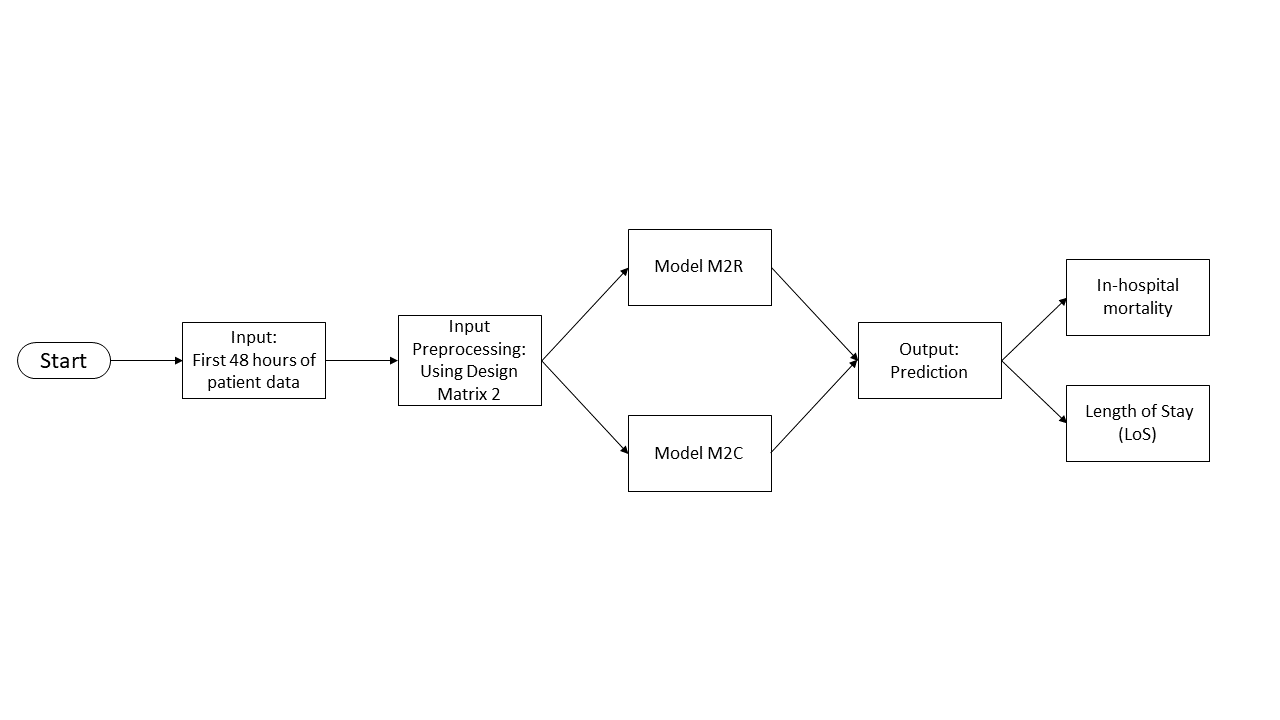

Firstly, input the first 48 hours of the patient data into either of the models, M2R or M2C. As the patient data is passed into either of the models, it will then be preprocessed using Design Matrix 2 which both models used this to preprocess input data. Design Matrix 2 transformed the input patient data in such a way that every parameters is grouped into a 12-hour bin (total of 4 bins for the first 48 hours). If a parameter is measured multiple times within a 12-hour bin, a mean of those measurement will be recorded to represent the measurement for that 12-hour bin instead. The data will then be used with Tensorflow in the Model for both M2R and M2C. 

For mortality prediction, the true positives is that a patient is predicted to die and he/she actually dies and the true negatives is that a patient is predicted to live and he/she lives. In an actual scenario which concerns life and death, this boils down to the morality for the prediction. Some patients prefer to know the 'truth', in this case, they want the actual result to be very close to the predicted one or in fact exactly the same as what was predicted and so sensitivity is very important to them. As the higher the sensitivity, the higher the chance the predicted result becomes true. They would rather be told that they are going to die and they actually die than being told that they will live, giving them false hope, but in the end die. A common myth of admission into ICU is that patients hardly have the chance of exiting alive. Thus, when one admits into the ICU, he/she is more concerned about whether he/she will die. To achieve the highest possible tpr (sensitivity) on the AUC curve, the point to choose on the curve will be as far to the right as possible. 